future project:
- don't drop GEOID's in dockless; figure out how they work for more accurate analysis
- add kiosk location by council district in bcycle to match dockless


links: 
- bcycle data: https://data.austintexas.gov/Transportation-and-Mobility/Austin-B-Cycle-Trips/tyfh-5r8s
- dockless data: https://data.austintexas.gov/Transportation-and-Mobility/Dockless-Vehicle-Trips/7d8e-dm7r 
- dockless city council map w/ numbers: http://www.austintexas.gov/GIS/CouncilDistrictMap/
- COA micromobility landing page: https://austintexas.gov/micromobility
- City of Austin District Representatives: https://www.austintexas.gov/government
- battery life, source 1: https://www.cnet.com/news/electric-scooters-bikes-dockless-ride-share-bird-lime-jump-spin-scoot/
- battery life, source 2: https://www.washingtonpost.com/local/trafficandcommuting/scooters-we-answer-your-questions-about-this-latest-transportation-trend/2018/11/10/a94b7d94-de03-11e8-85df-7a6b4d25cfbb_story.html?utm_term=.05c93aa0f747
- ojo/scoot vespa info: https://electrek.co/2019/01/22/ojo-electric-scooters/ 
veoride range info: https://news.uark.edu/articles/46123/veoride-bikeshare-program-adds-150-new-e-assist-bikes 
- scooter lifespan: https://mashable.com/article/escooter-lifespan-shared-new-models/ 

In [1]:
#Import libraries
from sklearn import preprocessing
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import operator
import seaborn as sns
sns.set_style('white')

#ml algos
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.options.display.max_rows = 30

## This dataset measures data from Austin's micromobility program from April 3, 2018 through June 18, 2019, which was the date I downloaded it from the AustinTexas.gov website. The data is updated on a weekly basis. 

In [2]:
#import csv for Austin B-Cycle Trip data
bcycle = pd.read_csv('Austin_B-Cycle_Trips.csv', encoding='latin1')
bcycle.to_csv('Austin_B-Cycle_Trips.csv.xz', compression='xz')
# , converters={2:str,}

/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#import csv for private dockless rideshare co's
dockless = pd.read_csv('Dockless_Vehicle_Trips.csv', encoding='latin1', converters={14:str, 15:str})
# , converters={14:str, 15:str}

# Section I - CITY OF AUSTIN B-CYCLE BIKE RENTAL PROGRAM

# Data Cleaning: City of Austin B-Cycle Bike Rental Program

## Before the dataset is altered, there are 1,171,610 recorded trips. This value will be used to calculate just how many of the rows dropped after the dataset is cleaned. 

In [4]:
# original number of trips
num_trips = len(bcycle)
print("There are {} trips in this dataset".format(num_trips))

There are 1171610 trips in this dataset


In [5]:
# data clean columns: 
bcycle.columns = bcycle.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

## We can drop Year and Month since ~50% of the values in both colummns are NaN while the Checkout Date are 100% filled.

In [6]:
bcycle.drop(['month', 'year'], 1, inplace=True)

In [7]:
bcycle.head(1)

,trip_id,membership_type,bicycle_id,checkout_date,checkout_time,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes
0,9900285854,Annual (San Antonio B-cycle),207,10/26/2014,13:12:00,2537.0,West & 6th St.,2707.0,Rainey St @ Cummings,76


## Cleanup -  bicycle_id

In [8]:
bcycle.loc[1077930]

trip_id                                 19000898
membership_type          U.T. Student Membership
bicycle_id                                  303G
checkout_date                         11/18/2018
checkout_time                           22:35:50
checkout_kiosk_id                           2547
checkout_kiosk                  Guadalupe & 21st
return_kiosk_id                             3838
return_kiosk                       Nueces & 26th
trip_duration_minutes                          7
Name: 1077930, dtype: object

In [9]:
bcycle.loc[bcycle.bicycle_id == '318', 'bicycle_id'].count()

0

In [10]:
bcycle['bicycle_id'] = bcycle.bicycle_id.astype(str)

In [11]:
bcycle.bicycle_id.apply(lambda x: type(x)).value_counts()

<class 'str'>    1171610
Name: bicycle_id, dtype: int64

In [12]:
bcycle['bicycle_id'] = bcycle['bicycle_id'].str.replace('G', '')

In [13]:
bcycle['bicycle_id'] = bcycle['bicycle_id'].str.replace('B', '')

In [14]:
bcycle['bicycle_id'] = bcycle['bicycle_id'].str.replace('E', '')
bcycle.bicycle_id.value_counts()

951.0    1896
387.0    1861
885.0    1855
925.0    1852
80.0     1844
696.0    1841
839.0    1840
969.0    1831
60.0     1829
281      1826
660.0    1822
37.0     1810
75.0     1808
185.0    1793
661.0    1790
         ... 
988.0      58
14190      49
987.0      17
933         5
579         5
15          5
483         4
459         4
393         4
176         3
195         3
805         2
165         2
974         1
980         1
Name: bicycle_id, Length: 1008, dtype: int64

In [15]:
bcycle['bicycle_id'] = bcycle.bicycle_id.astype(float)

In [16]:
bcycle['bicycle_id'].value_counts

<bound method IndexOpsMixin.value_counts of 0           207.0
1           969.0
2           214.0
3           745.0
4           164.0
5            37.0
6           517.0
7           996.0
8           517.0
9           385.0
10          133.0
11           52.0
12          206.0
13          241.0
14          478.0
            ...  
1171595     509.0
1171596     575.0
1171597     166.0
1171598      19.0
1171599     287.0
1171600     157.0
1171601     370.0
1171602     203.0
1171603     281.0
1171604     745.0
1171605     451.0
1171606      62.0
1171607     473.0
1171608     461.0
1171609    2197.0
Name: bicycle_id, Length: 1171610, dtype: float64>

In [17]:
#confirmed there are 723 NaN values out of 1.17 M
nan_bicycle_id = bcycle.bicycle_id.isnull().sum(axis=0)
nan_bicycle_id_percent = nan_bicycle_id / num_trips
print("There are {} rides with NaN values out of {} total rides, which is equal to {}."
      .format(nan_bicycle_id, num_trips, nan_bicycle_id_percent))

There are 723 rides with NaN values out of 1171610 total rides, which is equal to 0.0006170995467775113.


## It is safe to say that we can drop the NaN's in these column.

In [18]:
bcycle = bcycle.dropna(axis=0, subset=['bicycle_id'])

## I'm also creating a new dataframe to store the number of drops rows for future reference

In [19]:
dropped_rows = [nan_bicycle_id]

In [20]:
bcycle.isnull().sum()

trip_id                      0
membership_type           6463
bicycle_id                   0
checkout_date                0
checkout_time                0
checkout_kiosk_id        23131
checkout_kiosk               0
return_kiosk_id          24390
return_kiosk                 0
trip_duration_minutes        0
dtype: int64

In [21]:
bcycle['bicycle_id'] = bcycle.bicycle_id.astype(float)

In [22]:
bcycle.bicycle_id.apply(lambda x: type(x)).value_counts()

<class 'float'>    1170887
Name: bicycle_id, dtype: int64

In [23]:
pd.to_numeric(bcycle['bicycle_id'], downcast='float')

0           207.0
1           969.0
2           214.0
3           745.0
4           164.0
5            37.0
6           517.0
7           996.0
8           517.0
9           385.0
10          133.0
11           52.0
12          206.0
13          241.0
14          478.0
            ...  
1171595     509.0
1171596     575.0
1171597     166.0
1171598      19.0
1171599     287.0
1171600     157.0
1171601     370.0
1171602     203.0
1171603     281.0
1171604     745.0
1171605     451.0
1171606      62.0
1171607     473.0
1171608     461.0
1171609    2197.0
Name: bicycle_id, Length: 1170887, dtype: float32

In [24]:
bcycle.dtypes

trip_id                    int64
membership_type           object
bicycle_id               float64
checkout_date             object
checkout_time             object
checkout_kiosk_id        float64
checkout_kiosk            object
return_kiosk_id          float64
return_kiosk              object
trip_duration_minutes      int64
dtype: object

## Cleanup -  return and checkout kiosk ID's

## i need to see list of all columns with NaNs

In [25]:
bcycle.isnull().sum()

trip_id                      0
membership_type           6463
bicycle_id                   0
checkout_date                0
checkout_time                0
checkout_kiosk_id        23131
checkout_kiosk               0
return_kiosk_id          24390
return_kiosk                 0
trip_duration_minutes        0
dtype: int64

In [26]:

nan_checkout_k = bcycle.checkout_kiosk_id.isnull().sum(axis=0)
nan_checkout_kiosk_id_percent = nan_checkout_k / num_trips
print("There are {} rides with NaN values out of {} total rides, which is equal to {}."
      .format(nan_checkout_k, num_trips, nan_checkout_kiosk_id_percent))

There are 23131 rides with NaN values out of 1171610 total rides, which is equal to 0.019742917865159908.


In [27]:
nan_return_k = bcycle.return_kiosk_id.isnull().sum(axis=0)
nan_return_kiosk_id_percent = nan_return_k / num_trips
print("There are {} rides with NaN values out of {} total rides, which is equal to {} percent of the dataframe."
      .format(nan_return_k, num_trips, nan_return_kiosk_id_percent))

There are 24390 rides with NaN values out of 1171610 total rides, which is equal to 0.020817507532369987 percent of the dataframe.


In [28]:
nan_sum_ids = bcycle.apply(lambda row: True if pd.isnull(row['checkout_kiosk_id'])
             or pd.isnull(row['return_kiosk_id']) else False, axis='columns')
nan_sum_ids.sum()
var_sum_ids = nan_sum_ids.sum()

## Altogether, only 3.6% of the dataframe's rows have NaN's values in either the checkout or return kiosk ID, so I'm dropping them. 

In [29]:
percent_kiosks_dropped = var_sum_ids / num_trips
print("There are {} uniquw rows dropped from a total of {}, which is {} percent of the dataset."
      .format(var_sum_ids, num_trips, percent_kiosks_dropped))

There are 42430 uniquw rows dropped from a total of 1171610, which is 0.036215122779764596 percent of the dataset.


In [30]:
dropped_rows = [nan_checkout_k, nan_return_k]
print(dropped_rows)

[23131, 24390]


In [31]:
bcycle = bcycle.dropna(axis=0, subset=['checkout_kiosk_id', 'return_kiosk_id'])

In [32]:
bcycle.isnull().sum()

trip_id                     0
membership_type          6366
bicycle_id                  0
checkout_date               0
checkout_time               0
checkout_kiosk_id           0
checkout_kiosk              0
return_kiosk_id             0
return_kiosk                0
trip_duration_minutes       0
dtype: int64

In [33]:
bcycle.dtypes

trip_id                    int64
membership_type           object
bicycle_id               float64
checkout_date             object
checkout_time             object
checkout_kiosk_id        float64
checkout_kiosk            object
return_kiosk_id          float64
return_kiosk              object
trip_duration_minutes      int64
dtype: object

## Cleanup - membership_type

In [34]:
nan_membership_type = bcycle.membership_type.isnull().sum(axis=0)
nan_membership_type_percent = nan_checkout_k / num_trips
print("There are {} rides with NaN values out of {} total rides, which is equal to {}."
      .format(nan_membership_type, num_trips, nan_membership_type_percent))

There are 6366 rides with NaN values out of 1171610 total rides, which is equal to 0.019742917865159908.


In [35]:
bcycle = bcycle.dropna(axis=0, subset=['membership_type'])

## Convert checkout_date to a standardized to_datetime

In [36]:
bcycle['checkout_date'] = pd.to_datetime(bcycle['checkout_date'])

## There is also a mismatch betweent the number of unique Return & Checkout Kiosk and the corresponding ID's

In [37]:
bcycle['checkout_kiosk_id'].nunique()

96

In [38]:
bcycle['checkout_kiosk'].nunique()

100

In [39]:
bcycle['return_kiosk_id'].nunique()

96

In [40]:
bcycle['return_kiosk'].nunique()

99

## Memory

In [41]:
bcycle.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122091 entries, 0 to 1171609
Data columns (total 10 columns):
trip_id                  1122091 non-null int64
membership_type          1122091 non-null object
bicycle_id               1122091 non-null float64
checkout_date            1122091 non-null datetime64[ns]
checkout_time            1122091 non-null object
checkout_kiosk_id        1122091 non-null float64
checkout_kiosk           1122091 non-null object
return_kiosk_id          1122091 non-null float64
return_kiosk             1122091 non-null object
trip_duration_minutes    1122091 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 374.5 MB


things to reduce
bicycle id-> int 8
checkout ID-> int 16
return ID-> int 16
trip duration-> int 16
month-> int 8
year-> int 16

get dummies
membership
checkout kiosk
return kiosk

## I did a quick calculation of the average memory usage per column to verify...and it's a lot

In [42]:
# memory calc for B cycles data set
for dtype in ['float','int','object']:
    selected_dtype = bcycle.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
print("Average memory usage for {} columns: {:03.2f}MB".format(dtype,mean_usage_mb))

Average memory usage for object columns: 64.63MB


In [43]:
int_types = ["uint8", "int8", "int16"]
for it in int_types:
    print(np.iinfo(it))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------



In [44]:
# Created a function to save time
 
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series 
        usage_b = pandas_obj.memory_usage(deep=True)
        # convert bytes to megabytes
    usage_mb = usage_b / 1024 ** 2
    return usage_mb

In [45]:
bcycle_int = bcycle.select_dtypes(include=['int'])
converted_int = bcycle_int.apply(pd.to_numeric,downcast='unsigned')
print(mem_usage(bcycle_int))
print(mem_usage(converted_int))
compare_ints = pd.concat([bcycle_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

25.68262481689453
19.2619686126709


,before,after
uint16,NaN,1.0
int64,2.0,NaN
uint64,NaN,1.0


## Downcast columns

In [46]:
bcycle.head(5)

,trip_id,membership_type,bicycle_id,checkout_date,checkout_time,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes
0,9900285854,Annual (San Antonio B-cycle),207.0,2014-10-26,13:12:00,2537.0,West & 6th St.,2707.0,Rainey St @ Cummings,76
1,9900285855,24-Hour Kiosk (Austin B-cycle),969.0,2014-10-26,13:12:00,2498.0,Convention Center / 4th St. @ MetroRail,2566.0,Pfluger Bridge @ W 2nd Street,58
2,9900285856,Annual Membership (Austin B-cycle),214.0,2014-10-26,13:12:00,2537.0,West & 6th St.,2496.0,8th & Congress,8
6,9900285860,Annual Membership (Austin B-cycle),517.0,2014-10-26,13:12:00,2496.0,8th & Congress,2561.0,State Capitol Visitors Garage @ San Jacinto & ...,35
7,9900285861,Annual Membership (Austin B-cycle),996.0,2014-10-26,13:12:00,2569.0,East 11th St. & San Marcos,2499.0,City Hall / Lavaca & 2nd,11


In [47]:
bcycle.dtypes

trip_id                           int64
membership_type                  object
bicycle_id                      float64
checkout_date            datetime64[ns]
checkout_time                    object
checkout_kiosk_id               float64
checkout_kiosk                   object
return_kiosk_id                 float64
return_kiosk                     object
trip_duration_minutes             int64
dtype: object

In [48]:
bcycle['trip_id'] = pd.to_numeric(bcycle['trip_id'], errors='ignore', downcast='integer')

In [49]:
bcycle['bicycle_id'] = pd.to_numeric(bcycle['bicycle_id'], errors='ignore', downcast='integer')

In [50]:
bcycle['checkout_kiosk_id'] = pd.to_numeric(bcycle['checkout_kiosk_id'], errors='ignore', downcast='integer')

In [51]:
bcycle['return_kiosk_id'] = pd.to_numeric(bcycle['return_kiosk_id'], errors='ignore', downcast='integer')

In [52]:
bcycle['trip_duration_minutes'] = pd.to_numeric(bcycle['trip_duration_minutes'], errors='ignore', downcast='integer')

In [53]:
bcycle.dtypes

trip_id                           int64
membership_type                  object
bicycle_id                        int16
checkout_date            datetime64[ns]
checkout_time                    object
checkout_kiosk_id                 int16
checkout_kiosk                   object
return_kiosk_id                   int16
return_kiosk                     object
trip_duration_minutes             int16
dtype: object

## Add column measuring time in seconds to match Dockless dataset

In [54]:
bcycle['trip_duration_seconds'] = bcycle['trip_duration_minutes'] * 60

In [55]:
bcycle.head(2)

,trip_id,membership_type,bicycle_id,checkout_date,checkout_time,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds
0,9900285854,Annual (San Antonio B-cycle),207,2014-10-26,13:12:00,2537,West & 6th St.,2707,Rainey St @ Cummings,76,4560
1,9900285855,24-Hour Kiosk (Austin B-cycle),969,2014-10-26,13:12:00,2498,Convention Center / 4th St. @ MetroRail,2566,Pfluger Bridge @ W 2nd Street,58,3480


## Convert to positive time to eliminate negative time errors

In [56]:
bcycle['trip_duration_seconds'] = bcycle['trip_duration_seconds'].abs()

In [57]:
bcycle['trip_duration_minutes'] = bcycle['trip_duration_minutes'].abs()

## Eliminate whitespaces in kiosk_ids

In [58]:
bcycle['checkout_kiosk'] = bcycle['checkout_kiosk'].str.strip()
bcycle['return_kiosk'] = bcycle['return_kiosk'].str.strip()
pd.set_option('display.max_rows', 150)
bcycle.sort_values(by=['checkout_kiosk']).checkout_kiosk.unique()

array(['10th & Red River', '11th & Salina', '11th & San Jacinto',
       '13th & San Antonio', '17th & Guadalupe', '21st & Speedway @PCL',
       '21st & University', '22nd & Pearl', '23rd & Rio Grande',
       '23rd & San Jacinto @ DKR Stadium', '2nd & Congress', '3rd & West',
       '4th & Congress', '5th & Bowie', '5th & Campbell',
       '5th & San Marcos', '6th & Chalmers', '6th & Congress',
       '6th & Navasota St.', '8th & Congress', '8th & Guadalupe',
       '8th & Lavaca', 'ACC - Rio Grande & 12th',
       'ACC - West & 12th Street', 'Barton Springs & Riverside',
       'Barton Springs @ Kinney Ave', 'Barton Springs Pool',
       'Boardwalk West', 'Brazos & 6th', 'Bullock Museum @ Congress & MLK',
       'Capital Metro HQ - East 5th at Broadway',
       'Capitol Station / Congress & 11th', 'City Hall / Lavaca & 2nd',
       'Congress & Cesar Chavez', 'Convention Center / 3rd & Trinity',
       'Convention Center / 4th St. @ MetroRail', 'Davis at Rainey Street',
       'Dean 

## Save the new cleaned dataframe to csv for easier use.

In [59]:
bcycle.to_csv('bcycle_cleaned')

## Pickling BCycle

In [60]:
#import pickle


#new file anme
#filename = 'Bcycle-pickle'
# tell python to write a new file to my file name
#outfile = open(filename, 'wb')

#with the new file open, i can now save and pickle the file
#pickle.dump(bcycle,outfile)
#this closes the file
#outfile.close()

# Visualization & Exploration: City of Austin B-Cycle Bike Rental Program
## One issue we have with the Bcycle dataset is that while we do know the specific start and end location of each ride, we don't know know the actual distance traveled on any ride. 
## In the Dockless dataset we have the opposite problem: accurate distance traveled but no location specific information with start and end location. While we can't use the distance, we will use the ride duration as a proxy.
## We have a very long tail distribution, with the maximum ride being 10,981 minutes!

In [61]:
bcycle['trip_duration_minutes'].max()

10981

## As expected, the tail is too long to get a meaningful view of the distribution.

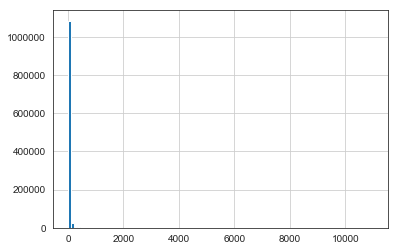

In [62]:
bcycle.trip_duration_minutes.hist(bins=100)

## According to Austin BCycle, no bike is supposed to be rented for more than 24 hours. Furthermore, "Checkouts lasting longer than 60 minutes will be charged an additional fee of 4 dollars(plus tax) for each additional 30 minutes past the first hour of a checkout..."

source: https://austinbcycle.com/how-it-works/faqs 

## Being charged 4 dollars every 30 minutes for 23 hours = 184 + 15.18 in tax (8.25% sales tax), or 199.18 dollars (!!!). That is a strong incentive to not have a bike ride last that long especially with other day-rental bike businesses available.

## With all of this in mind, I will cap what we could consider a real ride as up to 24 hours, which is 1,440 minutes. 

## I divided the range into four equal sections to visualize the distribution. It seems around the 1.5-2 hour mark (90-120 minutes) is when the long tail flattens significantly. Past then, the distribution becomes jagged.

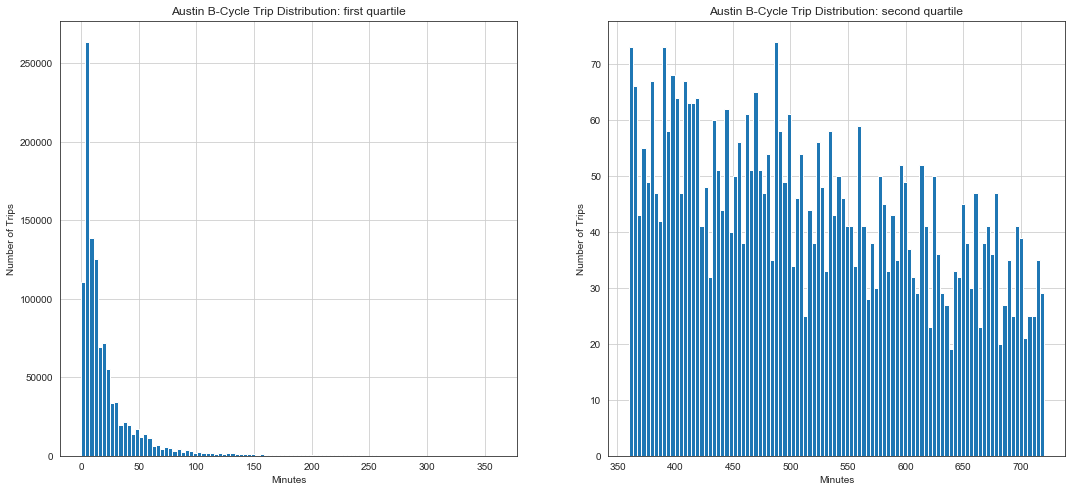

In [63]:

plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.title("Austin B-Cycle Trip Distribution: first quartile")
plt.ylabel("Number of Trips") 
plt.xlabel("Minutes")
bcycle.trip_duration_minutes.hist(bins=100, range=(0, 360))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
bcycle.trip_duration_minutes.hist(bins=100, range=(360, 720))
plt.title("Austin B-Cycle Trip Distribution: second quartile")
plt.ylabel("Number of Trips") 
plt.xlabel("Minutes")


plt.show()

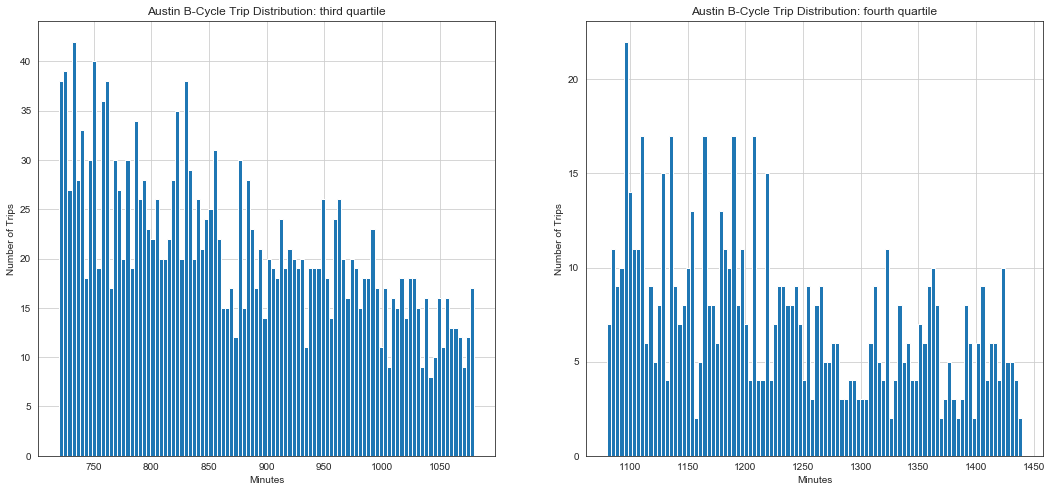

In [64]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.title("Austin B-Cycle Trip Distribution: third quartile")
plt.ylabel("Number of Trips") 
plt.xlabel("Minutes")
bcycle.trip_duration_minutes.hist(bins=100, range=(720, 1080))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
plt.title("Austin B-Cycle Trip Distribution: fourth quartile")
plt.ylabel("Number of Trips") 
plt.xlabel("Minutes")
bcycle.trip_duration_minutes.hist(bins=100, range=(1080, 1440))
plt.show()

## We can determine now that what we can categorize as a Real Ride is no longer than 1,440 minutes. But does the floor start at zero?

# False starts

## Unlike the Dockless dataset, there does not appear to be a massive amount of rides that went nowhere. While we do not have the distance traveled to verify that, there are several rides that lasted 0, 1, or 2 minutes.

## Since rides lasting 1 or 2 minutes are less than the number of rides measured for 3 minute rides combined, I will mark 0-2 minute rides as False Starts. This can be adjusted in the future for modeling purposes.

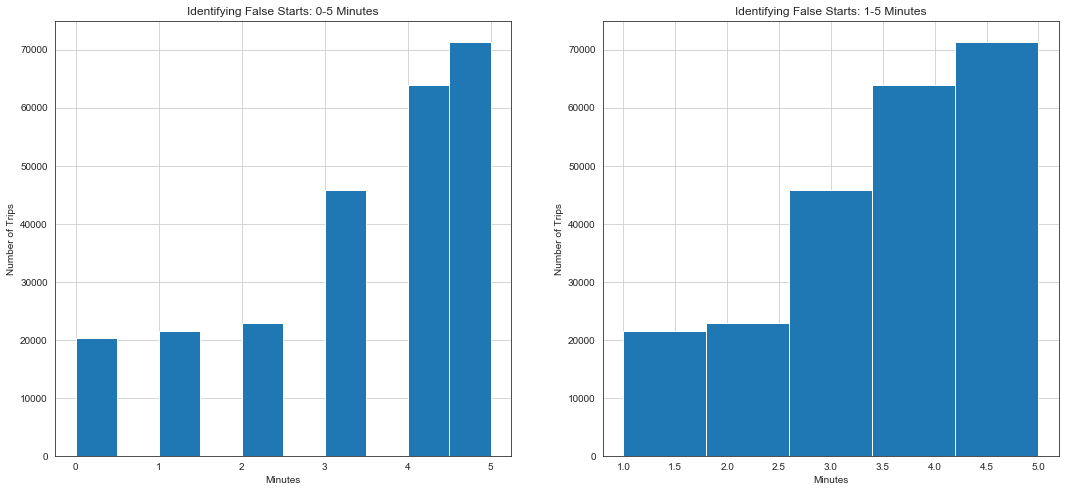

In [65]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
bcycle.trip_duration_minutes.hist(bins=10, range=(0, 5))
plt.title("Identifying False Starts: 0-5 Minutes")
plt.ylabel("Number of Trips") 
plt.xlabel("Minutes")

plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
bcycle.trip_duration_minutes.hist(bins=5, range=(1, 5))
plt.title("Identifying False Starts: 1-5 Minutes")
plt.ylabel("Number of Trips") 
plt.xlabel("Minutes")
plt.show()

______________________________________________________________________________________________________________________

______________________________________________________________________________________________________________________

______________________________________________________________________________________________________________________


# SECTION II: PRIVATE SECTOR DOCKLESS BIKE & SCOOTER SERVICES

## Data Cleaning: Private Sector Dockless Bike & Scooter Services

## There are 5.44 millions dockless rides and a very small amount of rows with NaN's

In [66]:
#visual aid for the rows with NaN's
dockless.isnull().sum()

ID                            0
Device ID                     0
Vehicle Type                  1
Trip Duration                 1
Trip Distance                 1
Start Time                    1
End Time                      1
Modified Date                 0
Month                         1
Hour                          1
Day of Week                   1
Council District (Start)    186
Council District (End)      186
Year                          1
Census Tract Start            0
Census Tract End              0
dtype: int64

In [67]:
# creating and printing the variable for the original number of rides in the dataset (including NaN's)
dockless_rides = len(dockless)
print(dockless_rides)

5442039


## How many unique rows have NaN's ?

In [68]:
# drop rows with NaN's
dockless = dockless.dropna(axis=0)

In [69]:
# confirmation all rows with NaN's are dropped
dockless.isnull().sum()

ID                          0
Device ID                   0
Vehicle Type                0
Trip Duration               0
Trip Distance               0
Start Time                  0
End Time                    0
Modified Date               0
Month                       0
Hour                        0
Day of Week                 0
Council District (Start)    0
Council District (End)      0
Year                        0
Census Tract Start          0
Census Tract End            0
dtype: int64

In [70]:
# creating and printing the variable for the number of rides in the dataset without NaN's
dockless_no_nans = len(dockless)
print(dockless_no_nans)

5441852


## 99.99% of the rides in this dataset don't have NaN values so we can safely drop the rows with NaN's.

In [71]:
nan_dockless_percent = dockless_no_nans / dockless_rides
print("There are {} rides without NaN values out of {} total rides, which is equal to {}."
      .format(dockless_no_nans, dockless_rides, nan_dockless_percent))

There are 5441852 rides without NaN values out of 5442039 total rides, which is equal to 0.9999656378794787.


# Cleaning up columns

In [72]:
# data clean columns: 
dockless.columns = dockless.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

## We can drop the modified_date columnsince it is just the date that, according to the AustinTexas.gov website:
## "The [modified_date is when]...the record was last modified (typically the date the data was extracted/loaded from the data provider), in local time (US/Central)."

In [73]:
dockless.drop(['modified_date'], axis=1, errors='coerce', inplace=True)

## Convert start/end time using to_datetime into a Unix timestamp

In [74]:
dockless.iloc[0].start_time

'11/30/2018 11:00:00 AM'

In [75]:
type(dockless.iloc[0].start_time)

str

In [76]:
from datetime import datetime
d = datetime.strptime('04/29/2019 05:30:00 PM', '%m/%d/%Y %I:%M:%S %p')
type(d)
d.strftime('%s')

'1556577000'

In [77]:
def str_to_timestamp(str):
    d = datetime.strptime(str, '%m/%d/%Y %I:%M:%S %p')
    return d.strftime('%s')

In [78]:
str_to_timestamp('04/29/2019 05:30:00 PM')

'1556577000'

In [79]:
#convert start time to unix timestamp
dockless.start_time.apply(str_to_timestamp)

1          1543597200
2          1556577000
3          1556577000
4          1556576100
5          1556577000
6          1556577000
7          1556575200
8          1556577000
9          1556576100
10         1556577000
11         1556577000
12         1556576100
13         1556576100
14         1556577000
15         1556577900
16         1556578800
17         1556577000
18         1556577900
19         1556577000
20         1556576100
21         1556577900
22         1556576100
23         1556577900
24         1556576100
25         1556576100
26         1556577000
27         1556577000
28         1556576100
29         1556576100
30         1556575200
31         1556575200
32         1556577000
33         1556576100
34         1556575200
35         1556576100
36         1556577000
37         1556575200
38         1556577000
39         1556577000
40         1556578800
41         1556577900
42         1556577000
43         1556577000
44         1556576100
45         1556576100
46        

## convert if needed

In [82]:
#convert end time to unix timestamp
#dockless.end_time.apply(str_to_timestamp)

## Memory adjustments

In [83]:
# memory calc for dockless data set
for dtype in ['float','int','object']:
    selected_dtype = dockless.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
print("Average memory usage for {} columns: {:03.2f}MB".format(dtype,mean_usage_mb))

Average memory usage for object columns: 378.11MB


In [84]:
dockless.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5441852 entries, 1 to 5442038
Data columns (total 15 columns):
id                        object
device_id                 object
vehicle_type              object
trip_duration             float64
trip_distance             float64
start_time                object
end_time                  object
month                     float64
hour                      float64
day_of_week               float64
council_district_start    float64
council_district_end      float64
year                      float64
census_tract_start        object
census_tract_end          object
dtypes: float64(8), object(7)
memory usage: 3.3 GB


## For the most part, all the trips start and end in the same Council District, with the exception being zone Zero starting at 5th place but ending at 8th.

In [85]:
len(dockless)

5441852

In [86]:
dockless['council_district_start'].value_counts()

9.0     4262556
3.0      498504
1.0      327468
5.0      189368
0.0       41656
7.0       37811
8.0       33117
10.0      28544
4.0       16669
2.0        5672
6.0         487
Name: council_district_start, dtype: int64

In [87]:
dockless['council_district_end'].value_counts()

9.0     4191987
3.0      514803
1.0      362081
5.0      203877
7.0       38961
8.0       38768
10.0      32538
0.0       31675
4.0       19330
2.0        7348
6.0         484
Name: council_district_end, dtype: int64

## According to the maps, there are only 10 Council Districts yet there are 11 districts in the data.

In [88]:
dockless.groupby('council_district_start').size()

council_district_start
0.0       41656
1.0      327468
2.0        5672
3.0      498504
4.0       16669
5.0      189368
6.0         487
7.0       37811
8.0       33117
9.0     4262556
10.0      28544
dtype: int64

In [89]:
dockless.groupby('council_district_end').size()

council_district_end
0.0       31675
1.0      362081
2.0        7348
3.0      514803
4.0       19330
5.0      203877
6.0         484
7.0       38961
8.0       38768
9.0     4191987
10.0      32538
dtype: int64

## Since the zones 9,3,1, and 5 are either part of Downtown Austin or adjacent to it, it is safe to say that the Districts are ordered numerically and zone zero may be used as a substitute for NaN or an unknown.

In [90]:
zone_zero_percent = dockless_no_nans / dockless_rides
print("There are {} rides without NaN values out of {} total rides, which is equal to {}."
      .format(dockless_no_nans, dockless_rides, nan_dockless_percent))

There are 5441852 rides without NaN values out of 5442039 total rides, which is equal to 0.9999656378794787.


In [91]:
#keeps only rows without 0.0 (drops due to more advanced requirements)
dockless = dockless[(dockless['council_district_start'] != 0.0) & (dockless['council_district_end'] != 0.0)]

In [92]:
dockless_0_drop = len(dockless)
print(dockless_0_drop)

5385031


In [93]:
# confirm new values
dockless['council_district_start'].value_counts()

9.0     4251227
3.0      497481
1.0      326440
5.0      188567
7.0       37370
8.0       32900
10.0      28399
4.0       16561
2.0        5621
6.0         465
Name: council_district_start, dtype: int64

In [94]:
# confirm new values
dockless['council_district_end'].value_counts()

9.0     4173210
3.0      512446
1.0      360235
5.0      202706
8.0       38546
7.0       38478
10.0      32383
4.0       19234
2.0        7316
6.0         477
Name: council_district_end, dtype: int64

## Even without those rows, we only dropped 1.04% of the original dataframe

In [95]:
dockless_0_percent = dockless_0_drop / dockless_rides
dockless_0_minus = (1-dockless_0_percent)
print("Even after dropping all the rows with 0.0, we still have {}% of the original dataframe, or just a {}% loss"
      .format(dockless_0_percent, dockless_0_minus))

Even after dropping all the rows with 0.0, we still have 0.9895245146166721% of the original dataframe, or just a 0.010475485383327876% loss


## Converting ID and Device_ID for consistency

In [96]:
dockless['id']= dockless['id'].astype(str)

In [97]:
dockless['device_id']= dockless['device_id'].astype(str)

In [98]:
dockless.dtypes

id                         object
device_id                  object
vehicle_type               object
trip_duration             float64
trip_distance             float64
start_time                 object
end_time                   object
month                     float64
hour                      float64
day_of_week               float64
council_district_start    float64
council_district_end      float64
year                      float64
census_tract_start         object
census_tract_end           object
dtype: object

## Convert columns to integers

In [99]:
dockless['trip_duration'] = pd.to_numeric(dockless['trip_duration'], errors='ignore', downcast='integer')

In [100]:
dockless['trip_distance'] = pd.to_numeric(dockless['trip_distance'], errors='ignore', downcast='integer')

In [101]:
dockless['month'] = pd.to_numeric(dockless['month'], errors='ignore', downcast='integer')

In [102]:
dockless['hour'] = pd.to_numeric(dockless['hour'], errors='ignore', downcast='integer')

In [103]:
dockless['day_of_week'] = pd.to_numeric(dockless['day_of_week'], errors='ignore', downcast='integer')

In [104]:
dockless['council_district_start'] = pd.to_numeric(dockless['council_district_start'], errors='ignore', downcast='integer')

In [105]:
dockless['council_district_end'] = pd.to_numeric(dockless['council_district_end'], errors='ignore', downcast='integer')

In [106]:
dockless['year'] = pd.to_numeric(dockless['year'], errors='ignore', downcast='integer')

In [107]:
dockless.sample(5)

,id,device_id,vehicle_type,trip_duration,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,census_tract_start,census_tract_end
1620450,e051a59a-1ca1-4a41-aace-bb66bc09170b,83330127-6497-4e1f-af5e-65d382cd5123,scooter,349,0,10/01/2018 03:30:00 PM,10/01/2018 03:45:00 PM,10,15,1,9,9,2018,48453000500,48453000601
1173816,9ea8f053-bfb8-479a-ae01-aed77f445839,44d1fddd-3ab9-40a3-898a-d1ba99c432a9,scooter,506,500,08/05/2018 04:45:00 PM,08/05/2018 04:45:00 PM,8,16,0,9,9,2018,48453001305,48453001305
3740166,f39d10c7-cadb-4828-be39-b569e5e78318,bc64be14-764b-439e-9c51-cc23d0ca2dee,scooter,234,0,11/29/2018 02:00:00 PM,11/29/2018 02:00:00 PM,11,14,4,9,9,2018,48453000601,48453000601
933709,b3efe15a-9c73-4709-8e98-a01e583c9859,ac33ed7c-d9a1-4a36-8caa-305324b4455d,scooter,650,1429,06/09/2019 02:30:00 PM,06/09/2019 02:45:00 PM,6,14,0,9,9,2019,48453001305,48453001100
3090495,adc0af18-4479-4f93-89d8-50647b54c580,f33d7e0f-e0f6-4a58-b268-d10a15d57a4a,scooter,269,695,04/17/2019 05:30:00 PM,04/17/2019 05:30:00 PM,4,17,3,9,9,2019,48453000601,48453000601


In [108]:
dockless.dtypes

id                        object
device_id                 object
vehicle_type              object
trip_duration              int32
trip_distance              int32
start_time                object
end_time                  object
month                       int8
hour                        int8
day_of_week                 int8
council_district_start      int8
council_district_end        int8
year                       int16
census_tract_start        object
census_tract_end          object
dtype: object

## Census GEOID cleanup

In [109]:
dockless['census_tract_end'] = dockless.census_tract_end.astype(float)

In [110]:
dockless['census_tract_start'] = dockless.census_tract_end.astype(float)

In [111]:
dockless['census_tract_start'] = pd.to_numeric(dockless['census_tract_start'], errors='ignore', downcast='integer')

In [112]:
dockless['census_tract_end'] = pd.to_numeric(dockless['census_tract_end'], errors='ignore', downcast='integer')

In [113]:
dockless.dtypes

id                        object
device_id                 object
vehicle_type              object
trip_duration              int32
trip_distance              int32
start_time                object
end_time                  object
month                       int8
hour                        int8
day_of_week                 int8
council_district_start      int8
council_district_end        int8
year                       int16
census_tract_start         int64
census_tract_end           int64
dtype: object

In [114]:
dockless.sample(5)

,id,device_id,vehicle_type,trip_duration,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,census_tract_start,census_tract_end
4095888,38afec93-75fb-4ffc-8ced-b53c3c9f5783,6d56fa7c-f56f-48b5-be6e-eafba511adce,scooter,239,1222,02/02/2019 05:30:00 PM,02/02/2019 05:30:00 PM,2,17,6,3,3,2019,48453000902,48453000902
2604153,18e34c05-696e-4b89-a4b1-012e0955818d,50bfffcb-69b9-40b8-90e7-f59bc205011c,scooter,2602,6312,11/04/2018 05:30:00 PM,11/04/2018 06:15:00 PM,11,17,0,9,1,2018,48453000700,48453000700
652235,c3ad722a-bebb-4e68-8df1-1fae32d32cfb,5e90e88e-5000-4481-890a-6f505195648c,scooter,931,2351,05/16/2019 04:45:00 PM,05/16/2019 05:15:00 PM,5,16,4,9,9,2019,48453002304,48453002304
894853,3a270485-c6fa-4753-b181-726cc2aa8b69,14b3a06f-b171-4870-aad4-9ec98bfdf920,scooter,548,1995,05/31/2019 09:45:00 PM,05/31/2019 10:00:00 PM,5,21,5,1,9,2019,48453001100,48453001100
2019377,4de792de-5565-4ef5-924b-5231bfde235a,f990c0d2-2013-4271-b81f-5237eabd5930,scooter,94,0,12/08/2018 12:45:00 PM,12/08/2018 12:45:00 PM,12,12,6,9,9,2018,48453000601,48453000601


## Vehicle type analysis and conversion to get_dummies

## Converted Scooter = 0 and Bike = 1

In [115]:
#dockless['vehicle_type'] = pd.get_dummies(dockless['vehicle_type'])

In [116]:
#dockless.vehicle_type.value_counts()

## ~95% of all dockless vehicle rides are Scooters

In [117]:
dockless.vehicle_type.value_counts(1)

scooter    0.951434
bicycle    0.048566
Name: vehicle_type, dtype: float64

## Drop GEO-ID columns

In [118]:
dockless.drop(['census_tract_start'], axis=1, errors='coerce', inplace=True)

In [119]:
dockless.drop(['census_tract_end'], axis=1, errors='coerce', inplace=True)

## Create a column so time values are consistent in minutes and secondsmin both datasets

In [120]:
dockless.rename(columns={'trip_duration':'trip_duration_seconds'}, inplace=True)

In [121]:
dockless['trip_duration_minutes'] = round((dockless['trip_duration_seconds'] / 60), 2)
dockless['trip_duration_minutes']

2           2.83
3           1.50
4           9.50
5           7.30
6           6.52
7           2.55
8           9.50
9          11.13
10          6.50
11          7.20
12          3.27
13         10.37
14         20.40
15          3.63
16          1.72
17          6.87
18          2.53
19          5.30
20          5.72
21          7.15
22         15.30
23          7.95
24          0.82
25          7.88
26         10.40
27          9.78
28         17.18
29          2.08
30         10.95
31          4.02
32          3.35
33          6.73
34          7.77
35          5.28
36          6.63
37          4.38
38          3.53
39          3.20
40          3.30
41          6.88
42          8.88
43         15.83
44          5.87
45          9.27
46          6.17
47         13.33
48          8.88
49          7.63
50          8.95
51          7.65
52          0.18
53         12.15
54          6.45
55          8.92
56         24.65
57          4.02
58          3.62
59         16.60
60         11.

In [122]:
dockless = dockless[['id', 'device_id', 'vehicle_type', 'trip_duration_minutes','trip_duration_seconds',
                    'trip_distance', 'start_time', 'end_time', 'month', 'hour', 'day_of_week',
                    'council_district_start', 'council_district_end', 'year']]

## I have a lot of negative values that are affecting the distribution

## Negative time

In [123]:
dockless[dockless['trip_duration_seconds']<0].count()

id                        6
device_id                 6
vehicle_type              6
trip_duration_minutes     6
trip_duration_seconds     6
trip_distance             6
start_time                6
end_time                  6
month                     6
hour                      6
day_of_week               6
council_district_start    6
council_district_end      6
year                      6
dtype: int64

In [124]:
indices = dockless[dockless['trip_duration_seconds']<0].index.tolist()
dockless.drop(indices, axis=0, inplace=True)

In [125]:
dockless[dockless['trip_duration_seconds']<0].count()

id                        0
device_id                 0
vehicle_type              0
trip_duration_minutes     0
trip_duration_seconds     0
trip_distance             0
start_time                0
end_time                  0
month                     0
hour                      0
day_of_week               0
council_district_start    0
council_district_end      0
year                      0
dtype: int64

## negative distance

In [126]:
dockless[dockless['trip_distance']<0].count()

id                        503
device_id                 503
vehicle_type              503
trip_duration_minutes     503
trip_duration_seconds     503
trip_distance             503
start_time                503
end_time                  503
month                     503
hour                      503
day_of_week               503
council_district_start    503
council_district_end      503
year                      503
dtype: int64

In [127]:
indices = dockless[dockless['trip_distance']<0].index.tolist()
dockless.drop(indices, axis=0, inplace=True)

In [128]:
dockless[dockless['trip_distance']<0].count()

id                        0
device_id                 0
vehicle_type              0
trip_duration_minutes     0
trip_duration_seconds     0
trip_distance             0
start_time                0
end_time                  0
month                     0
hour                      0
day_of_week               0
council_district_start    0
council_district_end      0
year                      0
dtype: int64

## Creating formula for avg scooter distance

In [129]:
dockless.sample(1)

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year
3256017,0f97327d-3883-450a-86ef-38ad82cdf667,c5e6f42e-34a8-4419-8f9e-b9a7af0b864e,bicycle,10.48,629,2108,01/02/2019 10:00:00 AM,01/02/2019 10:15:00 AM,1,10,3,9,9,2019


In [130]:
# convert meters to miles
# https://www.metric-conversions.org/length/meters-to-miles.htm
to_miles = 0.00062137

## Listing the different scooter & bike manufacturers with their respectives ranges based on one full battery charge

In [131]:
# different manufactured types of scooters or bike w/ their ranges in miles based on one full battery charge
xiaomi = 15
jump_bike = 40
lime_s = 37
vespa = 50
veo_bike = 68

## List of all dockless companies with permits and ranges calculated

In [132]:
# Bird permits and scooter range
bird_permits_scooter = 1000
bird_range_scooter = xiaomi 

In [133]:
# JUMP permits and scooter/bike ranges
jump_permits_scooter = 500
jump_permits_bike = 500

jump_range_scooter = xiaomi 
jump_range_bike = jump_bike 

In [134]:
# Lime scooter permits and range
lime_permits_scooter = 500
lime_range_scooter = lime_s 

In [135]:
# Lyft scooter permits and range
lyft_permits_scooter = 500
lyft_range_scooter = xiaomi

In [136]:
# OjO scooter permits and range
ojo_permits_scooter = 100
ojo_range_scooter = vespa 

In [137]:
# Skip scooter permits and range
skip_permits_scooter = 500
skip_range_scooter = vespa 

In [138]:
# Spin scooter permits and range
spin_permits_scooter = 500
skip_range_scooter = xiaomi

In [139]:
# VeoRide scooter & bike permits and range
veo_permits_scooter = 300
veo_permits_bike = 50

veo_range_scooter = xiaomi 
veo_range_bike = veo_bike

pap8 - stipulate how code should look (4 tabs, etc)
all code < 80 characters

## Permit Totals

In [140]:
# formula for scooter permits
total_scooter_permits = (bird_permits_scooter + 
                         jump_permits_scooter + 
                         lime_permits_scooter + 
                         lyft_permits_scooter +
                         ojo_permits_scooter +
                         skip_permits_scooter + 
                         spin_permits_scooter + 
                         veo_permits_scooter)
print(total_scooter_permits)

3900


In [141]:
#formula for bike permits
total_bike_permits = (jump_permits_bike + veo_permits_bike)
print(total_bike_permits)

550


## Permit Percentages

In [142]:
# formulas for scooter weighted avg
bird_s_pct = bird_permits_scooter / total_scooter_permits
jump_s_pct = jump_permits_scooter / total_scooter_permits
lime_s_pct = lime_permits_scooter / total_scooter_permits
lyft_s_pct = lyft_permits_scooter / total_scooter_permits
ojo_s_pct = ojo_permits_scooter / total_scooter_permits
skip_s_pct = skip_permits_scooter / total_scooter_permits
spin_s_pct = spin_permits_scooter / total_scooter_permits
veo_s_pct = veo_permits_scooter / total_scooter_permits

In [143]:
# formulas for bike weighted avg
jump_b_pct = jump_permits_bike / total_bike_permits
veo_b_pct = veo_permits_bike / total_bike_permits
print(jump_b_pct)
print(veo_b_pct)

0.9090909090909091
0.09090909090909091


In [144]:
permit_totals = [bird_permits_scooter, jump_permits_scooter, lime_permits_scooter, lyft_permits_scooter,
                        ojo_permits_scooter, skip_permits_scooter, spin_permits_scooter, veo_permits_scooter]

for permit in permit_totals:
    print(permit / total_scooter_permits)

0.2564102564102564
0.1282051282051282
0.1282051282051282
0.1282051282051282
0.02564102564102564
0.1282051282051282
0.1282051282051282
0.07692307692307693


## Pickling Dockless

In [145]:
#new file name
#filename2 = 'dockless-pickle'
# tell python to write a new file to my file name
#outfile = open(filename2, 'wb')

#with the new file open, i can now save and pickle the file
#pickle.dump(dockless,outfile)
#this closes the file
#outfile.close()

# Section II: Data Visualization & Exploration

## One issue we have with the Bcycle dataset is that while we do know the specific start and end location of each ride, we don't know know the actual distance. 
## In the Dockless dataset we have the opposite problem: we have an accurate distance traveled but no location specific information with the start and end locations to preserve anonymity. While we can't use the distance, we will use the ride duration as a proxy.

## Dockless trip_distance distributions

In [146]:
# creating a new variable to capture the shortened distribution
df_distance = dockless.loc[(dockless['trip_distance'] <= 15373.8)]
len(df_distance)

5379848

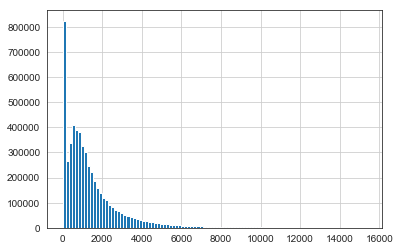

In [147]:
df_distance.trip_distance.hist(bins=100)

## Outliers were affecting the distributions after ~8,000 meters (4.87 miles) so we narrowed the rides we observed to see the long tail more accurately at a max of 15,383.8 meters

## Limiting to 15,373.8 meters kept 99.9% of the ride data for analysis

In [148]:
# division of new variable up to 15,373.8 m divided by the total number of rides in the dataset
len(df_distance) / len(dockless)

0.9991319563742148

 # Furthermore, <1% of the rides extend beyond 8000 meters (4.87 mi)

In [149]:
dockless.loc[(dockless['trip_distance'] >= 8000)].count()

id                        49854
device_id                 49854
vehicle_type              49854
trip_duration_minutes     49854
trip_duration_seconds     49854
trip_distance             49854
start_time                49854
end_time                  49854
month                     49854
hour                      49854
day_of_week               49854
council_district_start    49854
council_district_end      49854
year                      49854
dtype: int64

In [150]:
49854 / len(df_distance)

0.009266804563995116

## There is a high occurence of what appears to be "false starts," so I explored where a single value or a range is responsible

# Starting from range 100-8000 eliminated the clustered data

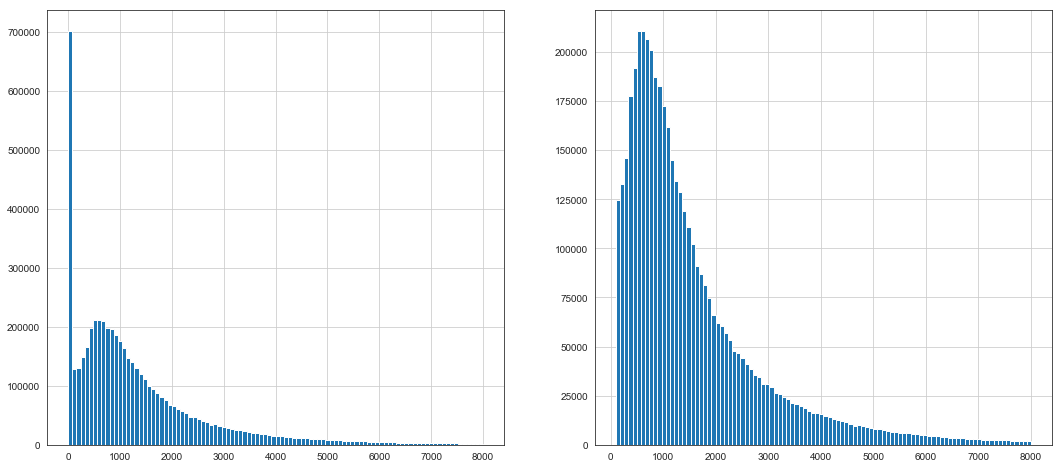

In [151]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
df_distance.trip_distance.hist(bins=100, range=(0,8000))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
df_distance.trip_distance.hist(bins=100, range=(100,8000))
plt.show()

## 1-100 and 1-10 was not as helpful as I expected

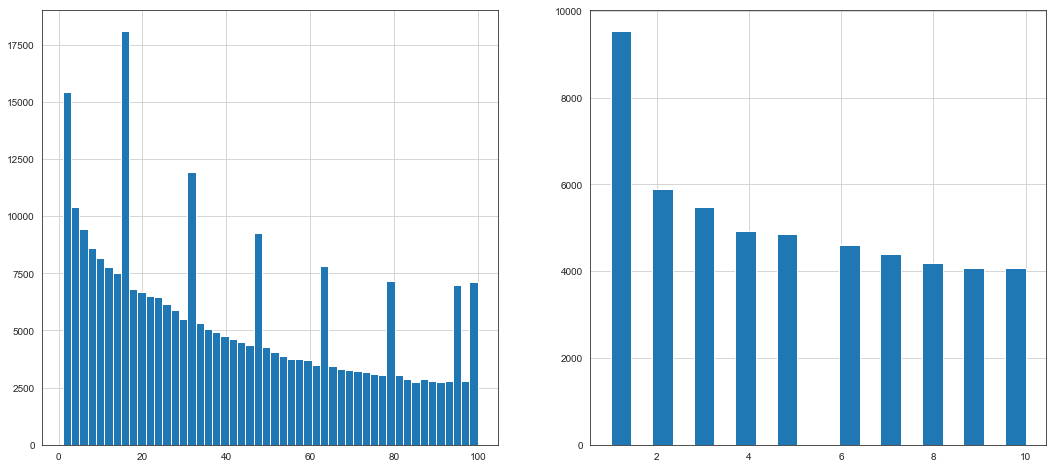

In [152]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
df_distance.trip_distance.hist(bins=50, range=(1,100))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
df_distance.trip_distance.hist(bins=20, range=(1,10))

## However, it is clear that the bunched up values are not a range but rather just zero

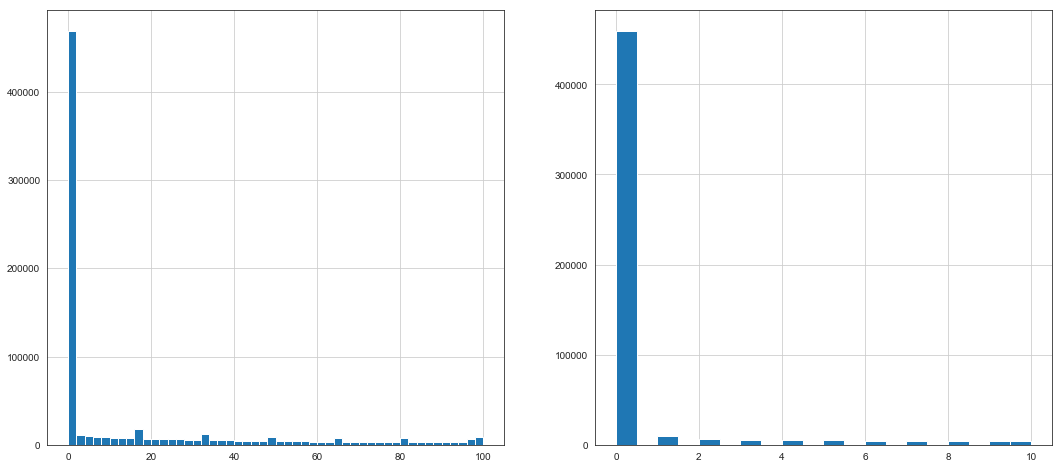

In [153]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
df_distance.trip_distance.hist(bins=50, range=(0,100))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
df_distance.trip_distance.hist(bins=20, range=(0,10))

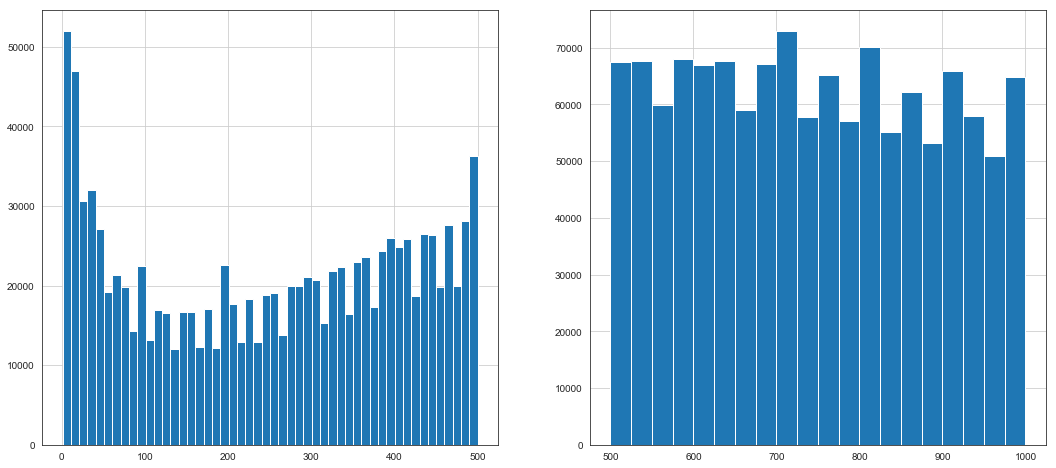

In [154]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
df_distance.trip_distance.hist(bins=50, range=(1,500))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
df_distance.trip_distance.hist(bins=20, range=(500,1000))

## I need to recreate a variable that removes both false starts (trip distance >1 m) and outliers (>8000 meters)

In [155]:
normal_dockless_rides = dockless.loc[(dockless['trip_distance'] > 1) & (dockless['trip_distance'] <= 8000)]
len(normal_dockless_rides)

4865705

## ~90% of the rides are considered within this range

In [156]:
len(normal_dockless_rides) / len(dockless)

0.9036466003853267

## While clear, the scooter data's range (which is ~95% of the original data) is hiding the distribution of the bike data.

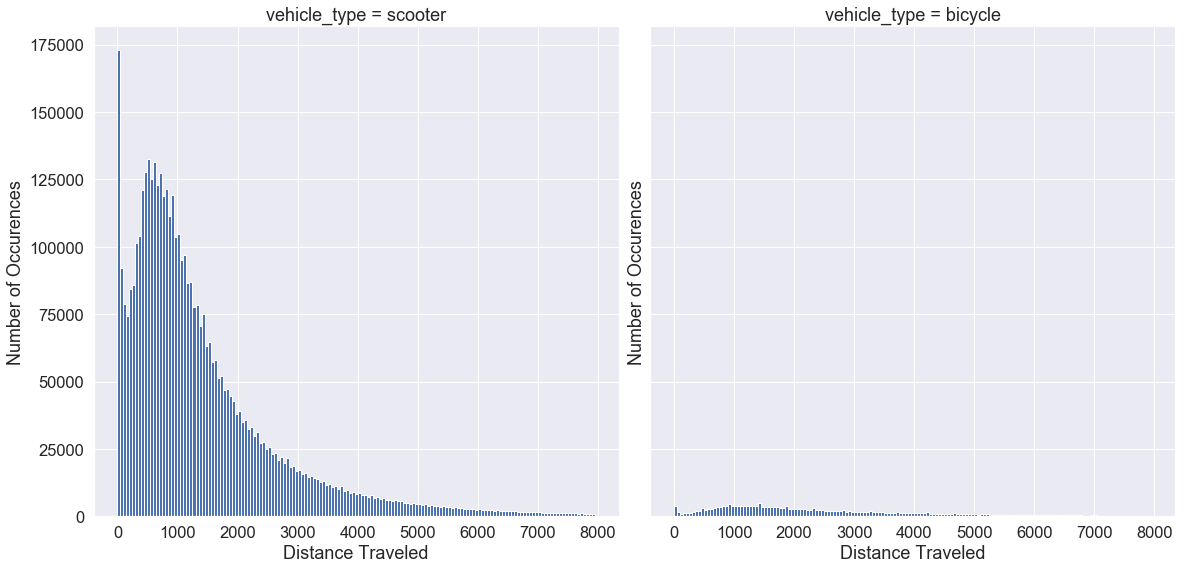

In [157]:
sns.set_style("whitegrid")
sns.set_palette("BuGn_r")
sns.set(font_scale=1.5) 

bins = np.arange(0, 8000, 50)
dockless_types = sns.FacetGrid(normal_dockless_rides, col='vehicle_type', height=8.27)
dockless_types.map(plt.hist, "trip_distance", bins=bins)
dockless_types.set(xlabel='Distance Traveled', ylabel='Number of Occurences')

## I created a new dataframe for only real dockless scooters and bikes where the trip duration and distance was >= 1

In [158]:
normal_dockless_rides_s = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 8000)
                                    & (dockless['vehicle_type'] == 'scooter')
                                    & (dockless['trip_duration_seconds'] >= 1)]


In [159]:
normal_dockless_rides_b = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 8000)
                                    & (dockless['vehicle_type'] == 'bicycle')
                                    & (dockless['trip_duration_seconds'] >= 1)]

In [160]:
normal_dockless_rides_s.head(1)

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year
4,1d4f5d89-c044-46cb-8674-80d37fa0371f,caa0325c-7c0b-4909-a573-d83126ecc953,scooter,9.5,570,826,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,4,17,1,9,9,2019


In [161]:
normal_dockless_rides_b.head(1)

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year
829,30b1f786-7385-49fc-b4f6-153d95a2f1e4,a1798c71-19a2-4efe-85fa-3726eee8ceb3,bicycle,14.7,882,2349,04/29/2019 12:15:00 PM,04/29/2019 12:30:00 PM,4,12,1,9,9,2019


## It appears that while both have similar distribution shapes, the bike rides tend to cover longer distances

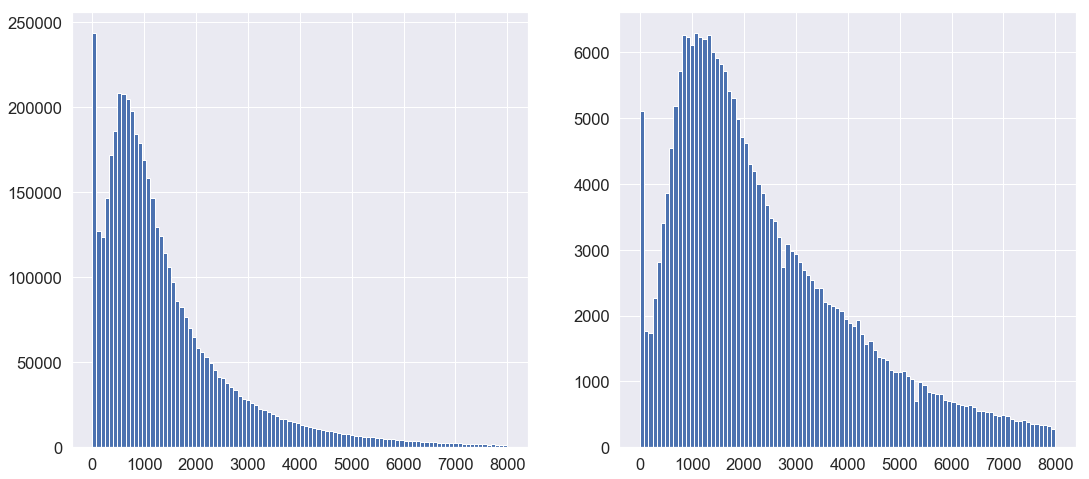

In [162]:
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
normal_dockless_rides_s.trip_distance.hist(bins=100)
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
normal_dockless_rides_b.trip_distance.hist(bins=100)
plt.show()

## Day of Week analysis

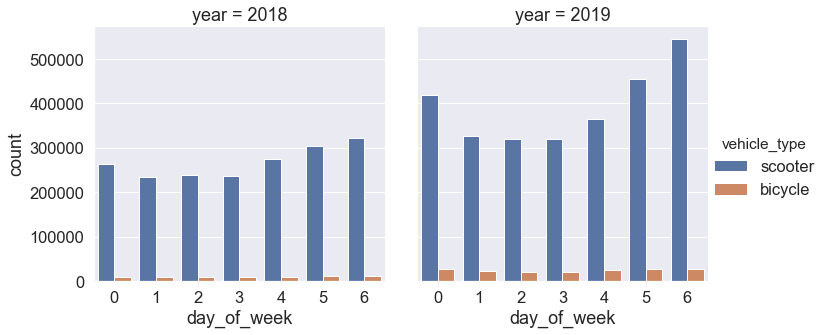

In [163]:
sns.catplot(x="day_of_week", hue="vehicle_type", col='year', 
            data=normal_dockless_rides, kind='count')

## Even though the data from 2019 has three fewer months worth compared to 2018, there is about  ~50% more data which speaks to the increased adoption rate in the city.

In [164]:
count_2018 = len(normal_dockless_rides.loc[(normal_dockless_rides['year'] == 2018)])
count_2019 = len(normal_dockless_rides.loc[(normal_dockless_rides['year'] == 2019)])

print("The total number of real rides in 2018 was {}.".format(count_2018))
print("The total number of real rides in 2019 was {}.".format(count_2019))

The total number of real rides in 2018 was 1943415.
The total number of real rides in 2019 was 2922290.


## Now that we have a better idea of the trip distance distribution as a whole, what about the individual dockless scooters & bikes themselves? What can the unique devices tell us about all these rides

## The most used scooter was riden 693 times

In [165]:
# created a new variable for how frequently unique devices were used
device_freq = dockless.device_id.value_counts()
device_freq

e9de6733-842d-46c6-bdec-2b1bb3ce6e78    693
c501eef0-c361-4c25-9489-acaff8a3eeeb    679
6cb1120f-282a-4894-89e7-395a13b1f1d0    645
460665fe-f0b7-4fb8-a537-50b5e33cf066    640
fa8de131-5904-4daa-8483-52ab9fea3e86    635
45b01aae-956f-43dc-8e19-41e8bf8ff751    634
c5a230c9-7e80-4464-862f-f2b23f61d6d3    629
d6f2fc5a-3d0e-468f-9877-f058e711a36a    625
b114da11-7a03-4fbc-a0ae-99c7bc62d3cc    624
62c3da38-3838-45c2-be6d-f579b65daf11    617
a4b4b5f3-146a-44c3-bfe2-5cced39ac109    617
8cdc86b5-3a01-4655-a580-0a02e9d05b5b    614
66b3ee16-b8b0-45b0-82de-393e1d12016f    613
a3252fef-c4ce-4de9-a446-c23495f720c8    612
86a87a7f-fea7-4899-b8a9-b67a7284733f    612
5e4baa97-2064-4392-8aff-d0d129561cf4    612
b001293e-e336-4672-95e8-07c7906c5a21    611
b5025f6a-7238-453d-865d-8cd293159726    608
4478fe94-894f-4c4f-a1ab-a67a70739be5    602
30950953-6044-4c36-8b2c-c1ed4ab2ec3c    597
1b58e93f-1f57-42e9-a5e8-adcf4ed193d8    593
209fb255-01da-469a-9dfe-b35c045f29f8    591
aa72dd8d-8d43-4c46-866f-0a9af04a

## Similar to the distance distribution, we also have a long tail with how heavily used scooters are used.

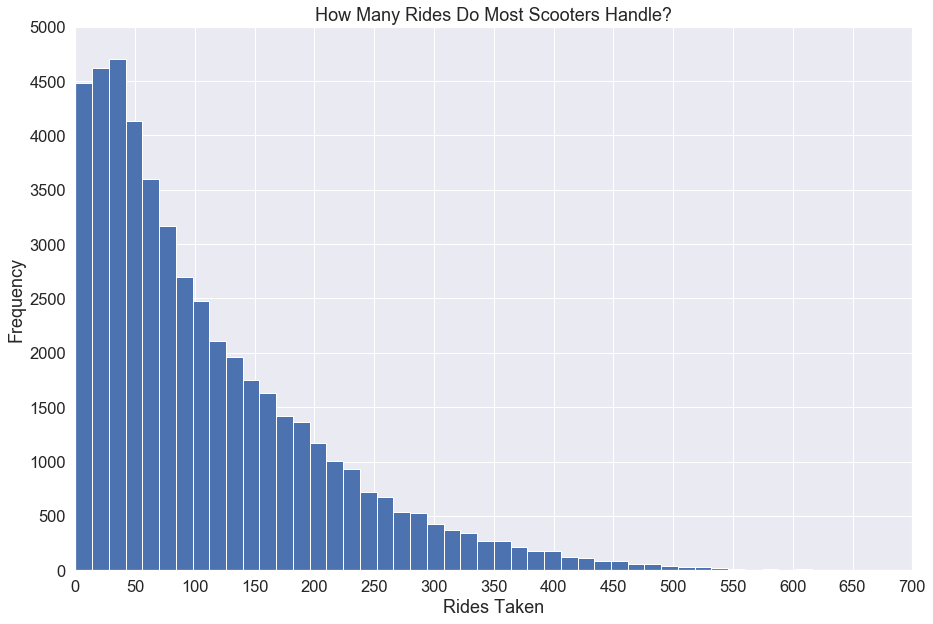

In [166]:
# The full distribution

plt.figure(figsize=[15, 10])
d_id_plot = device_freq.hist(bins=50, range=(0, 700))
plt.title('How Many Rides Do Most Scooters Handle?')
plt.xlabel('Rides Taken')
plt.ylabel('Frequency')
unique_devices = d_id_plot.set(xlim=(0,700),
                ylim=(0,5000),
                xticks=[0,50, 100, 150, 200, 250, 300, 350,
                        400, 450, 500, 550, 600, 650, 700],
                yticks=[0, 500, 1000, 1500, 2000, 2500, 3000, 3500,
                        4000, 4500, 5000])


## The tail is a bit extended and not as smooth as the distance distribution. Perhaps this rigid curve has something to do with the individual scooters themselves?

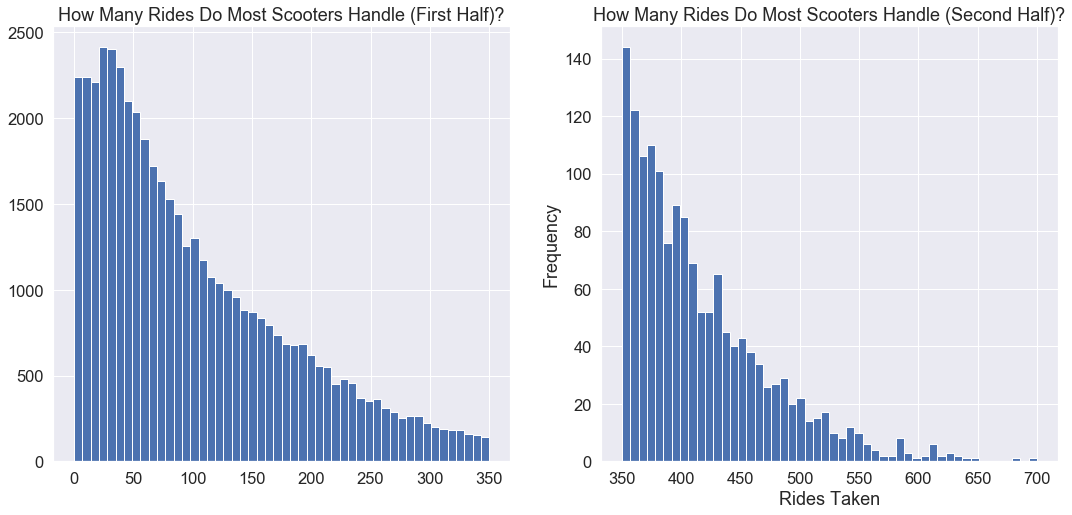

In [167]:
#The distribution cut in half
plt.figure(figsize=[18,8])
plt.subplot(1, 2, 1, autoscale_on=True)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
d_id_ax1 = device_freq.hist(bins=50, range=(0, 350))
plt.subplot(1, 2, 2, autoscale_on=True)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
d_id_ax2 = device_freq.hist(bins=50, range=(350, 700))

plt.xlabel('Rides Taken')
plt.ylabel('Frequency')
d_id_ax1.title.set_text('How Many Rides Do Most Scooters Handle (First Half)?')
d_id_ax2.title.set_text('How Many Rides Do Most Scooters Handle (Second Half)?')


plt.show()

In [168]:
dockless.head()

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,scooter,2.83,170,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,1.50,90,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019
4,1d4f5d89-c044-46cb-8674-80d37fa0371f,caa0325c-7c0b-4909-a573-d83126ecc953,scooter,9.50,570,826,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,4,17,1,9,9,2019
5,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,scooter,7.30,438,1815,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4,17,1,9,9,2019
6,e1ac0e42-ab2d-4eac-b019-f085169c1d38,1d89f9e2-d01a-4736-b7d8-258cb9a2108c,scooter,6.52,391,1519,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019


## So how many scooters had a false start?

In [169]:
mask_false_start = dockless.trip_distance == 0

In [170]:
mask_scooter = dockless.vehicle_type == 'scooter'

In [171]:
mask_bike = dockless.vehicle_type == 'bicycle'

In [172]:
dockless_false_start_s = dockless[mask_false_start & mask_scooter] 

In [173]:
dockless_false_start_b = dockless[mask_false_start & mask_bike] 

In [174]:
mask_false_start.sum()

459537

In [175]:
mask_scooter.sum()

5122997

In [176]:
mask_bike.sum()

261525

In [177]:
(mask_scooter & mask_bike).sum()

0

## Number of False Starts

In [178]:
(mask_scooter & mask_false_start).sum()

450156

In [179]:
(mask_bike & mask_false_start).sum()

9381

# Section IV: Feature Engineering

## To unify the two datasets, I need to create a feature for:
## 1. The average speed for scooters and bikes in the dockless dataset so I can calculate the distance traveled in the bcycle dataset. Unfortunately, the bcycle dataset only provides trip duration with the start and end location. While imperfect, this will give me a best available estimate (distance = speed X time).
## 2. The number of trips 
## 3. An odometer for each unique scooter than updates with each ride.
## 4. A Classifier for whether a ride is a false start or not; for dockless it is =0 and in Bcycle it is = to 0-2 

## This will also help with my pairplots and heatmaps to bettter view relationships.

## Unpickling the data for Features engineering

In [180]:
#infile = open(filename,'rb')
#p_bcycle = pickle.load(infile)
#infile.close()


In [181]:
#infile = open(filename2,'rb')
#p_dockless = pickle.load(infile)
#infile.close()


## 1. Creating Average Speed Feature

In [182]:
# speed = distance / time. Creating a new column for avg speed.
dockless['avg_speed'] = round((dockless['trip_distance'] / dockless['trip_duration_seconds']), 2)

In [183]:

#Calling the varaible again to no include the new 'avg_speed' column
normal_dockless_rides_s = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 8000)
                                    & (dockless['vehicle_type'] == 'scooter')
                                    & (dockless['trip_duration_seconds'] >= 1)]

normal_dockless_rides_b = dockless.loc[(dockless['trip_distance'] >= 1)
                                    & (dockless['trip_distance'] <= 8000)
                                    & (dockless['vehicle_type'] == 'bicycle')
                                    & (dockless['trip_duration_seconds'] >= 1)]

In [184]:
normal_dockless_rides_s.head(5)

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,avg_speed
4,1d4f5d89-c044-46cb-8674-80d37fa0371f,caa0325c-7c0b-4909-a573-d83126ecc953,scooter,9.50,570,826,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,4,17,1,9,9,2019,1.45
5,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,scooter,7.30,438,1815,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4,17,1,9,9,2019,4.14
6,e1ac0e42-ab2d-4eac-b019-f085169c1d38,1d89f9e2-d01a-4736-b7d8-258cb9a2108c,scooter,6.52,391,1519,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,3.88
8,1c8b3eab-6aed-4b69-8eca-6b5e0b70a45f,ab262134-2421-49b7-a97f-fadde23e71db,scooter,9.50,570,1843,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4,17,1,9,9,2019,3.23
9,f9174176-9d16-431d-af21-ebcab226da31,73e8b0bf-3aae-4f80-8683-c5d7c3b3989a,scooter,11.13,668,2829,04/29/2019 05:15:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,4.24


## Scooter mean & median, meters / second

In [185]:
# mean
normal_dockless_rides_s['avg_speed'].mean()

2.479222024200258

In [186]:
# median
normal_dockless_rides_s['avg_speed'].median()

2.38

## Bike mean & median, meters / second

In [187]:
# mean
normal_dockless_rides_b['avg_speed'].mean()

3.311363981968178

In [188]:
# median
normal_dockless_rides_b['avg_speed'].median()

3.32

In [189]:
# saving this variable to use in Bcycle; meters / second
avg_bike_speed = normal_dockless_rides_b['avg_speed'].mean()

## Since we don't have a column with distance information in BCycle, we will use the average speed we found in Dockless to understand the distance these bikes may have taken.
## Applying Trip_Distance using our new bike speed 

In [190]:
# distance = speed x time; rounding up to conserve space
bcycle['trip_distance'] = round((avg_bike_speed * bcycle.trip_duration_seconds), 2)

In [191]:
bcycle.trip_distance.head(3)

0    15099.82
1    11523.55
2     1589.45
Name: trip_distance, dtype: float64

## 2. The number of trips per unique device

In [192]:
# new variable to measure length of dataset
device_id_set_length_dock = len(set(dockless['device_id']))

# Dictionary to store cumulative counts
device_id_dict_dock = dict(zip(set(dockless['device_id']), np.zeros(device_id_set_length_dock)))

# Empty list to store running count
running_count_dock = []

# Loop through all values
for row in dockless.itertuples():
  device_id_dict_dock[row[2]] += 1
  running_count_dock.append(device_id_dict_dock[row[2]])
  
dockless['device_id_trip_count'] = running_count_dock

In [193]:
dockless.head(1)

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,avg_speed,device_id_trip_count
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,scooter,2.83,170,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,0.0,1.0


## Let's see if it is successfully counting by searching for a specific ID...and it is!

In [194]:
dockless.loc[dockless.device_id == '746fbee1-3a56-4275-8f0f-b36862d1bb53']

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,avg_speed,device_id_trip_count
31586,4290a0f9-4c21-483a-a130-3914a960b6f3,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,11.47,688,1325,04/06/2019 07:15:00 PM,04/06/2019 07:30:00 PM,4,19,6,9,1,2019,1.93,1.0
2121437,6c6883c8-6f25-4436-8b17-abf73011e939,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,3.42,205,692,03/11/2019 04:45:00 PM,03/11/2019 04:45:00 PM,3,16,1,9,9,2019,3.38,2.0
2124150,4c89f32a-2f22-48e3-828a-e7cc1e16b636,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,8.57,514,2100,12/27/2018 04:15:00 PM,12/27/2018 04:15:00 PM,12,16,4,3,3,2018,4.09,3.0
2134238,2e919792-d0ab-47fe-9037-8a035db3edf2,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,12.73,764,2782,03/09/2019 10:00:00 PM,03/09/2019 10:15:00 PM,3,22,6,3,9,2019,3.64,4.0
2134999,7f2dd0a6-7511-4058-8412-af4cc72a7e63,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,2.15,129,138,03/09/2019 03:45:00 PM,03/09/2019 03:45:00 PM,3,15,6,9,9,2019,1.07,5.0
2135081,f0f85ff5-0706-44bc-8497-ae35a1e01af1,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,37.35,2241,517,03/09/2019 07:00:00 PM,03/09/2019 07:30:00 PM,3,19,6,9,9,2019,0.23,6.0
2136096,bf082e57-d5ae-4d46-9b8b-0108662aca72,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,34.50,2070,6093,03/29/2019 06:00:00 PM,03/29/2019 06:30:00 PM,3,18,5,9,1,2019,2.94,7.0
2147911,bb1e77c9-52f4-4ac3-9ed6-8c5008c67245,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,2.42,145,213,03/09/2019 06:00:00 PM,03/09/2019 06:00:00 PM,3,18,6,9,9,2019,1.47,8.0
2149215,e43dd1e1-65a2-49bc-8d2e-163f457ac98a,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,28.25,1695,1500,10/31/2018 03:45:00 PM,10/31/2018 04:15:00 PM,10,15,3,1,1,2018,0.88,9.0
2152166,976234a4-9108-4b24-812a-4fde73adafd6,746fbee1-3a56-4275-8f0f-b36862d1bb53,scooter,81.13,4868,8124,03/12/2019 09:00:00 PM,03/12/2019 10:15:00 PM,3,21,2,9,9,2019,1.67,10.0


## Now we will do the same in the BCycle data set

In [195]:
# new variable to measure length of dataset
device_id_set_length_bcycle = len(set(bcycle['bicycle_id']))

# Dictionary to store cumulative counts
device_id_dict_bcycle = dict(zip(set(bcycle['bicycle_id']), np.zeros(device_id_set_length_bcycle)))

# Empty list to store running count
running_count_bcycle = []

# Loop through all values; the row has to be changed to 3 to count the bicycle_id column
for row in bcycle.itertuples():
  device_id_dict_bcycle[row[3]] += 1
  running_count_bcycle.append(device_id_dict_bcycle[row[3]])
  
bcycle['device_trip_count'] = running_count_bcycle

## Verified that it is counting trips

In [196]:
bcycle.loc[bcycle.bicycle_id == 969]

,trip_id,membership_type,bicycle_id,checkout_date,checkout_time,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds,trip_distance,device_trip_count
1,9900285855,24-Hour Kiosk (Austin B-cycle),969,2014-10-26,13:12:00,2498,Convention Center / 4th St. @ MetroRail,2566,Pfluger Bridge @ W 2nd Street,58,3480,11523.55,1.0
598,9900286446,Semester Membership (Austin B-cycle),969,2014-10-27,13:12:00,2495,4th & Congress,2552,3rd & West,3,180,596.05,2.0
606,9900286454,Semester Membership (Austin B-cycle),969,2014-10-27,13:12:00,2552,3rd & West,2495,4th & Congress,0,0,0.00,3.0
761,9900286609,Semester Membership (Austin B-cycle),969,2014-10-27,17:12:00,2495,4th & Congress,2567,Palmer Auditorium,8,480,1589.45,4.0
900,9900286746,24-Hour Kiosk (Austin B-cycle),969,2014-10-28,1:12:00,2567,Palmer Auditorium,2503,South Congress & James,10,600,1986.82,5.0
2117,9900287946,Annual Membership (Austin B-cycle),969,2014-10-30,17:12:00,2499,City Hall / Lavaca & 2nd,2712,Toomey Rd @ South Lamar,9,540,1788.14,6.0
2180,9900288008,24-Hour Kiosk (Austin B-cycle),969,2014-10-30,19:12:00,2712,Toomey Rd @ South Lamar,2712,Toomey Rd @ South Lamar,82,4920,16291.91,7.0
2233,9900288060,24-Hour Kiosk (Austin B-cycle),969,2014-10-31,7:12:00,2712,Toomey Rd @ South Lamar,2495,4th & Congress,11,660,2185.50,8.0
2485,9900288305,24-Hour Kiosk (Austin B-cycle),969,2014-10-31,14:12:00,2550,Republic Square @ Guadalupe & 4th St.,2572,Barton Springs Pool,24,1440,4768.36,9.0
2585,9900288403,24-Hour Kiosk (Austin B-cycle),969,2014-10-31,16:12:00,2572,Barton Springs Pool,2552,3rd & West,15,900,2980.23,10.0


## 3. The odometer per unique device

## Testing the odometer on a single device_id

In [197]:
odometer_test1 = dockless[dockless.device_id == '6b90a827-60a1-47ad-94a4-d33654dbd50d']

In [198]:
test_odo = odometer_test1.trip_distance.cumsum()

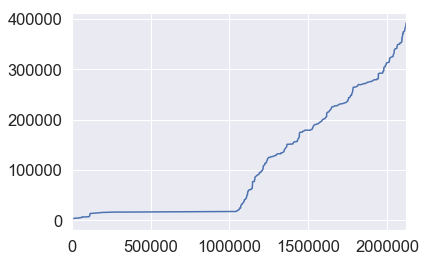

In [199]:
test_odo.plot()

## Making the Odometer on a large scale

In [200]:
dockless['odometer'] = dockless.groupby('device_id')['trip_distance'].transform(pd.Series.cumsum)

## Verified that it works using a random device_id

In [201]:
dockless.loc[dockless.device_id == '1e5234a3-e86b-41e1-a1ad-e98310f3a71c']

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,avg_speed,device_id_trip_count,odometer
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,1.50,90,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,0.00,1.0,0
96,e0ea4c37-91c1-4e57-9393-1dd5b72e2f78,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,5.80,348,1183,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,3.40,2.0,1183
598,d7ee689e-bfe2-4d38-8ef4-f75984493305,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,6.72,403,1173,04/29/2019 05:45:00 PM,04/29/2019 05:45:00 PM,4,17,1,9,9,2019,2.91,3.0,2356
883,c9b6872a-a8cd-4fb2-bf93-ec137130fc40,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,13.83,830,1851,05/10/2019 07:15:00 PM,05/10/2019 07:30:00 PM,5,19,5,9,3,2019,2.23,4.0,4207
8214,0fffd64c-5e46-4fac-a49c-3b5392c3260d,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,6.83,410,1193,05/26/2019 12:00:00 AM,05/26/2019 12:00:00 AM,5,0,0,9,9,2019,2.91,5.0,5400
17112,c3b37a52-fe0e-402c-bf60-e1fd9615f7af,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,5.67,340,1667,04/12/2019 04:00:00 PM,04/12/2019 04:00:00 PM,4,16,5,3,9,2019,4.90,6.0,7067
17181,3251782f-690a-4446-b767-8a6ece84a6dd,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,5.03,302,1102,05/02/2019 11:15:00 PM,05/02/2019 11:15:00 PM,5,23,4,3,3,2019,3.65,7.0,8169
18714,c47f1787-ccaa-45f0-b253-011010656259,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,5.03,302,739,04/27/2019 11:15:00 PM,04/27/2019 11:15:00 PM,4,23,6,9,9,2019,2.45,8.0,8908
20310,649ef453-43e1-4d11-807c-cc3c5ccb068a,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,4.57,274,793,04/30/2019 01:45:00 AM,04/30/2019 01:45:00 AM,4,1,2,9,9,2019,2.89,9.0,9701
37754,a38455ae-1f56-45b8-a0d8-54bc715217f2,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,6.15,369,1085,05/02/2019 10:45:00 PM,05/02/2019 11:00:00 PM,5,22,4,3,3,2019,2.94,10.0,10786


## Now I'll do the same for the Bcycle dataset

In [202]:
# odometer
bcycle['odometer'] = bcycle.groupby('bicycle_id')['trip_distance'].transform(pd.Series.cumsum)

In [203]:
# verify the odometer works
bcycle.loc[bcycle.bicycle_id == 207]

,trip_id,membership_type,bicycle_id,checkout_date,checkout_time,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds,trip_distance,device_trip_count,odometer
0,9900285854,Annual (San Antonio B-cycle),207,2014-10-26,13:12:00,2537,West & 6th St.,2707,Rainey St @ Cummings,76,4560,15099.82,1.0,15099.82
151,9900286004,24-Hour Kiosk (Austin B-cycle),207,2014-10-26,15:12:00,2707,Rainey St @ Cummings,2707,Rainey St @ Cummings,64,3840,12715.64,2.0,27815.46
207,9900286058,24-Hour Kiosk (Austin B-cycle),207,2014-10-26,17:12:00,2707,Rainey St @ Cummings,2565,Trinity & 6th Street,205,12300,40729.78,3.0,68545.24
1908,9900287737,24-Hour Kiosk (Austin B-cycle),207,2014-10-30,10:12:00,2707,Rainey St @ Cummings,2707,Rainey St @ Cummings,366,21960,72717.55,4.0,141262.79
2732,9900288549,24-Hour Kiosk (Austin B-cycle),207,2014-10-31,21:12:00,2548,UT West Mall @ Guadalupe,2547,Guadalupe & 21st,142,8520,28212.82,5.0,169475.61
2902,9900288725,Walk Up,207,2015-10-01,21:12:36,2565,Trinity & 6th Street,2497,Capitol Station / Congress & 11th,7,420,1390.77,6.0,170866.38
3017,9900288838,RideScout Single Ride,207,2015-10-01,9:12:37,2565,Trinity & 6th Street,2565,Trinity & 6th Street,1,60,198.68,7.0,171065.06
3492,9900289344,Walk Up,207,2015-10-02,19:12:34,2542,Plaza Saltillo,2567,Palmer Auditorium,1203,6644,22000.70,8.0,193065.76
3891,9900289766,Weekender,207,2015-10-02,16:12:33,2574,Zilker Park,2550,Republic Square @ Guadalupe & 4th St.,14,840,2781.55,9.0,195847.31
3940,9900289815,Weekender,207,2015-10-02,16:12:13,2497,Capitol Station / Congress & 11th,2567,Palmer Auditorium,11,660,2185.50,10.0,198032.81


# 4. Creating a Classifier 

## Dockless Classifier

In [204]:
mask_trip_class_dock = dockless['trip_distance'] > 0
# 0 = real ride; 1 = false start
dockless['trip_type'] = np.where(mask_trip_class_dock, 0, 1)
dockless.head()

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,avg_speed,device_id_trip_count,odometer,trip_type
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,scooter,2.83,170,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,0.00,1.0,0,1
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,1.50,90,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,0.00,1.0,0,1
4,1d4f5d89-c044-46cb-8674-80d37fa0371f,caa0325c-7c0b-4909-a573-d83126ecc953,scooter,9.50,570,826,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,4,17,1,9,9,2019,1.45,1.0,826,0
5,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,scooter,7.30,438,1815,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4,17,1,9,9,2019,4.14,1.0,1815,0
6,e1ac0e42-ab2d-4eac-b019-f085169c1d38,1d89f9e2-d01a-4736-b7d8-258cb9a2108c,scooter,6.52,391,1519,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,3.88,1.0,1519,0


## Bcycle Classifier

## Establishing that a real ride is >=  1 minute long

In [205]:

mask_trip_class_bcycle = bcycle['trip_distance'] >= 3
# 0 = real ride; 1 = false start
bcycle['trip_type'] = np.where(mask_trip_class_bcycle, 0, 1)
dockless.head()

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,avg_speed,device_id_trip_count,odometer,trip_type
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,scooter,2.83,170,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,0.00,1.0,0,1
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,1.50,90,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,0.00,1.0,0,1
4,1d4f5d89-c044-46cb-8674-80d37fa0371f,caa0325c-7c0b-4909-a573-d83126ecc953,scooter,9.50,570,826,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,4,17,1,9,9,2019,1.45,1.0,826,0
5,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,scooter,7.30,438,1815,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4,17,1,9,9,2019,4.14,1.0,1815,0
6,e1ac0e42-ab2d-4eac-b019-f085169c1d38,1d89f9e2-d01a-4736-b7d8-258cb9a2108c,scooter,6.52,391,1519,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,3.88,1.0,1519,0


## Reduce my features to save memory - Bcycle

In [206]:
bcycle['trip_distance'] = pd.to_numeric(bcycle['trip_distance'], errors='ignore', downcast='integer')

In [207]:
bcycle['device_trip_count'] = pd.to_numeric(bcycle['device_trip_count'], errors='ignore', downcast='integer')

In [208]:
bcycle['odometer'] = pd.to_numeric(bcycle['odometer'], errors='ignore', downcast='integer')

In [209]:
bcycle['trip_type'] = pd.to_numeric(bcycle['trip_type'], errors='ignore', downcast='integer')

In [210]:
bcycle.dtypes

trip_id                           int64
membership_type                  object
bicycle_id                        int16
checkout_date            datetime64[ns]
checkout_time                    object
checkout_kiosk_id                 int16
checkout_kiosk                   object
return_kiosk_id                   int16
return_kiosk                     object
trip_duration_minutes             int16
trip_duration_seconds             int16
trip_distance                   float64
device_trip_count                 int16
odometer                        float64
trip_type                          int8
dtype: object

## Reduce my features to save memory - Dockless

In [211]:
dockless.head(1)

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,avg_speed,device_id_trip_count,odometer,trip_type
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,scooter,2.83,170,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,0.0,1.0,0,1


In [212]:
dockless['avg_speed'] = pd.to_numeric(dockless['avg_speed'], errors='ignore', downcast='float')

In [213]:
dockless['device_id_trip_count'] = pd.to_numeric(dockless['device_id_trip_count'], errors='ignore', downcast='integer')

In [214]:
dockless['odometer'] = pd.to_numeric(dockless['odometer'], errors='ignore', downcast='integer')

In [215]:
dockless['trip_type'] = pd.to_numeric(dockless['trip_type'], errors='ignore', downcast='integer')

In [216]:
dockless.dtypes

id                         object
device_id                  object
vehicle_type               object
trip_duration_minutes     float64
trip_duration_seconds       int32
trip_distance               int32
start_time                 object
end_time                   object
month                        int8
hour                         int8
day_of_week                  int8
council_district_start       int8
council_district_end         int8
year                        int16
avg_speed                 float32
device_id_trip_count        int16
odometer                    int64
trip_type                    int8
dtype: object

# Section V: Model Time

In [217]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest


# As a reminder, my hypothesis is that the wear and tear on the scooters and bikes has a relationship with how likely the ride will register a trip_distance of zero.

## Plotting Learning Curves

## SelectKBest Features & Establish train_test_split

In [219]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [220]:
# drop the extra columns
X = bcycle.drop(['trip_type', 'checkout_kiosk', 'return_kiosk', 'checkout_time', 'checkout_date'],  1)
# create a value for the various membership types so it can pass and get insight
X = pd.get_dummies(X, columns=['membership_type'])
# predicting for trip type 
Y = bcycle['trip_type']
# test train split function
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [288]:
member_dummies = pd.get_dummies(bcycle.membership_type)

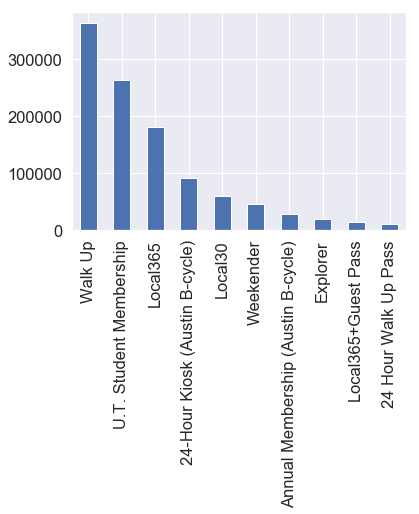

In [299]:
bcycle.membership_type.value_counts()[0:10].plot(kind='bar')

In [286]:
bcycle.membership_type.value_counts(ascending=False)

Walk Up                                               363176
U.T. Student Membership                               262383
Local365                                              179413
24-Hour Kiosk (Austin B-cycle)                         91201
Local30                                                59179
Weekender                                              44767
Annual Membership (Austin B-cycle)                     27895
Explorer                                               17894
Local365+Guest Pass                                    12812
24 Hour Walk Up Pass                                   10093
Single Trip                                             6899
Single Trip                                             5366
3-Day Explorer                                          4740
Local365 ($80 plus tax)                                 4004
Founding Member                                         3461
Local365- 1/2 off Anniversary Special                   3010
7-Day                   

In [282]:
X.head(1)

,trip_id,bicycle_id,checkout_kiosk_id,return_kiosk_id,trip_duration_minutes,trip_duration_seconds,trip_distance,device_trip_count,odometer,membership_type_$1 Pay by Trip Fall Special,...,membership_type_Semester Membership (Austin B-cycle),membership_type_Single Trip,membership_type_Single Trip,membership_type_Single Trip Ride,membership_type_Try Before You Buy Special,membership_type_U.T. Student Membership,membership_type_UT Student Membership,membership_type_Walk Up,membership_type_Weekender,membership_type_Weekender ($15 plus tax)
0,9900285854,207,2537,2707,76,4560,15099.82,1,15099.82,0,...,0,0,0,0,0,0,0,0,0,0


In [221]:
selector = SelectKBest(k=25)
X_new = selector.fit_transform(X_train, y_train)
names = X.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_bcycle = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
ns_bcycle_sorted = ns_bcycle.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_bcycle_sorted)

                                           Feat_names     F_Scores
4                               trip_duration_seconds  5116.117336
5                                       trip_distance  5116.117195
21              membership_type_RideScout Single Ride  3210.945421
3                               trip_duration_minutes  1662.298139
23            membership_type_U.T. Student Membership   198.861030
19                         membership_type_PROHIBITED   140.942166
6                                   device_trip_count   136.806105
7                                            odometer   131.517909
0                                             trip_id   125.089673
1                                   checkout_kiosk_id   119.266956
24                            membership_type_Walk Up    99.021000
20                         membership_type_RESTRICTED    56.881806
2                                     return_kiosk_id    51.162189
8       membership_type_$1 Pay by Trip Winter Special    41.31

## Heatmap

In [ ]:
import seaborn as sns
heat_ax = sns.heatmap(flights, cmap="YlGnBu")

## Bcycle - NB Classifier

In [222]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
cross_gnb = cross_val_score(gnb, X_train, y_train, cv=10)
print(cross_gnb)
print("Cross Validation Mean: ", cross_gnb.mean())

[ 0.9817605   0.9817605   0.98176028  0.98176028  0.98176028  0.98176028
  0.98177195  0.98177195  0.98177195  0.98177195]
Cross Validation Mean:  0.981764991108


In [301]:
cross_gnb.var()

3.2265667053754806e-11

In [224]:
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,
    random_state=seed)
# fit model on training data
gnb.fit(X_train, y_train)
# make predictions for test data
predictions_gnb = gnb.predict(X_test)
# evaluate predictions
accuracy_gnb = accuracy_score(y_test, predictions_gnb)
print("Accuracy: %.2f%%" % (accuracy_gnb * 100.0))

Accuracy: 98.17%


In [238]:
# Classify, storing the result in a new variable.
y_pred = gnb.predict(X_test)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X.shape,
    (y_test != y_pred).sum()
))

Number of mislabeled points out of a total (1122091, 79) points : 5121


In [271]:
len(X_test)

280523

In [241]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 

results_gnb = confusion_matrix(y_test, y_pred) 
print('\nConfusion Matrix :')
print(results_gnb) 
print('Accuracy Score :',accuracy_score(y_test, y_pred))
print('\nReport : ')
print(classification_report(y_test, y_pred))


Confusion Matrix :
[[275402      0]
 [  5121      0]]
Accuracy Score : 0.981744812368

Report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    275402
           1       0.00      0.00      0.00      5121

   micro avg       0.98      0.98      0.98    280523
   macro avg       0.49      0.50      0.50    280523
weighted avg       0.96      0.98      0.97    280523



/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [243]:
print('\nR-squared:')
print(gnb.score(X_test, y_test))


R-squared:
0.981744812368


## Bcycle - Random Forest Classifier

In [250]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier

In [252]:
rfc = ensemble.RandomForestClassifier()
cross_rfc = cross_val_score(rfc, X_train, y_train, cv=10)
print(cross_rfc)
print("Cross Validation Mean: ", cross_rfc.mean())

/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jakegrosek/anacon

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Cross Validation Mean:  1.0


In [302]:
cross_rfc.var()

0.0

In [253]:
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,
    random_state=seed)
# fit model on training data
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)
# make predictions for test data
predictions_rfc = rfc.predict(X_test)
# evaluate predictions
accuracy_rfc = accuracy_score(y_test, predictions_rfc)
print("Accuracy: %.2f%%" % (accuracy_rfc * 100.0))

/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 100.00%


In [254]:
# Classify, storing the result in a new variable.
y_pred = rfc.predict(X_test)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X.shape[0],
    (y_test != y_pred).sum()
))

Number of mislabeled points out of a total 1122091 points : 0


In [256]:
# RFC confusion matrix
results_rfc = confusion_matrix(y_test, y_pred) 
print('\nConfusion Matrix :')
print(results_rfc) 
print('Accuracy Score :',accuracy_score(y_test, y_pred))
print('\nReport : ')
print(classification_report(y_test, y_pred))


Confusion Matrix :
[[275402      0]
 [     0   5121]]
Accuracy Score : 1.0

Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    275402
           1       1.00      1.00      1.00      5121

   micro avg       1.00      1.00      1.00    280523
   macro avg       1.00      1.00      1.00    280523
weighted avg       1.00      1.00      1.00    280523



In [257]:
print('\nR-squared:')
print(rfc.score(X_test, y_test))


R-squared:
1.0


## XGBoost - BCycle

In [258]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb = XGBClassifier()

In [259]:
cross_xgb = cross_val_score(xgb, X_train, y_train, cv=10)
print(cross_xgb)
print("Cross Validation Mean: ", cross_xgb.mean())

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Cross Validation Mean:  1.0


In [303]:
cross_xgb.var()

0.0

In [260]:
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,
    random_state=seed)
# fit model on training data
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
# make predictions for test data
predictions = xgb.predict(X_test)
# evaluate predictions
accuracy_xgb = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy_xgb * 100.0))

Accuracy: 100.00%


In [261]:
# Classify, storing the result in a new variable.
y_pred = xgb.predict(X_test)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X.shape[0],
    (y_test != y_pred).sum()
))

Number of mislabeled points out of a total 1122091 points : 0


In [262]:
# XGB confusion matrix
results_xgb = confusion_matrix(y_test, y_pred) 
print('\nConfusion Matrix :')
print(results_xgb) 
print('Accuracy Score :',accuracy_score(y_test, y_pred))
print('\nReport : ')
print(classification_report(y_test, y_pred))


Confusion Matrix :
[[275402      0]
 [     0   5121]]
Accuracy Score : 1.0

Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    275402
           1       1.00      1.00      1.00      5121

   micro avg       1.00      1.00      1.00    280523
   macro avg       1.00      1.00      1.00    280523
weighted avg       1.00      1.00      1.00    280523



In [263]:
print('\nR-squared:')
print(xgb.score(X_test, y_test))


R-squared:
1.0


## Logistic Regression

In [264]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=7, solver='lbfgs', multi_class='multinomial')

In [266]:
cross_val_score(lr, X, Y, cv=10)
cross_lr = cross_val_score(lr, X_train, y_train, cv=10)
print(cross_lr)
print("Cross Validation Mean: ", cross_lr.mean())

[ 0.98198605  0.98192664  0.98192664  0.98192664  0.98192664  0.98192664
  0.98192664  0.98192664  0.98192642  0.98192642]
Cross Validation Mean:  0.981932535443


In [304]:
cross_lr.var()

3.1820664939644782e-10

In [305]:
cv_means = cross_lr.mean()

In [320]:
cv_var_lr = [(x-cross_lr.mean())**2 for x in cross_lr] 
(sum(var1)) / len(cross_lr)

3.1820664939644782e-10

In [267]:
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,
    random_state=seed)
# fit model on training data
lr.fit(X_train, y_train)
# make predictions for test data
predictions = lr.predict(X_test)
# evaluate predictions
accuracy_lr = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy_lr * 100.0))

Accuracy: 98.17%


In [268]:
# Classify, storing the result in a new variable.
y_pred = lr.predict(X_test)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X.shape[0],
    (y_test != y_pred).sum()
))

Number of mislabeled points out of a total 1122091 points : 5121


In [269]:
# XGB confusion matrix
results_lr = confusion_matrix(y_test, y_pred) 
print('\nConfusion Matrix :')
print(results_lr) 
print('Accuracy Score :',accuracy_score(y_test, y_pred))
print('\nReport : ')
print(classification_report(y_test, y_pred))


Confusion Matrix :
[[275402      0]
 [  5121      0]]
Accuracy Score : 0.981744812368

Report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    275402
           1       0.00      0.00      0.00      5121

   micro avg       0.98      0.98      0.98    280523
   macro avg       0.49      0.50      0.50    280523
weighted avg       0.96      0.98      0.97    280523



/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [270]:
print('\nR-squared:')
print(lr.score(X_test, y_test))


R-squared:
0.981744812368


## Lasso Logistic Regression

In [344]:
from sklearn.linear_model import LogisticRegression
lasso = LogisticRegression(random_state=7, penalty='l1', solver='liblinear')

In [ ]:
cross_val_score(lasso, X, Y, cv=10)
cross_lasso = cross_val_score(lasso, X_train, y_train, cv=10)
print(cross_lasso)
print("Cross Validation Mean: ", cross_lasso.mean())

In [ ]:
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,
    random_state=seed)
# fit model on training data
lasso.fit(X_train, y_train)
# make predictions for test data
predictions = lasso.predict(X_test)
# evaluate predictions
accuracy_lasso = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy_lr * 100.0))

In [ ]:
# Classify, storing the result in a new variable.
y_pred = lasso.predict(X_test)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    X.shape[0],
    (y_test != y_pred).sum()
))

In [ ]:
# Lasso confusion matrix
results_lasso = confusion_matrix(y_test, y_pred) 
print('\nConfusion Matrix :')
print(results_lasso) 
print('Accuracy Score :',accuracy_score(y_test, y_pred))
print('\nReport : ')
print(classification_report(y_test, y_pred))

In [ ]:
print('\nR-squared:')
print(lasso.score(X_test, y_test))

## Dockless Models